# Modeling and Regression Analysis 

## Model Selection & Feature Engineering
 

### Variable Selection

1. GDP Growth Rate (gdp_growth)
 - Unit: Percentage (%), Quarter-over-Quarter

2. Inflation Rate (inflation)
 - Unit: Percentage (%), year-over-year growth rate

3. Unemployment Rate (unemployment)
 - Unit: Percentage (%)
 - Justification:
    - Labor market health indicator - measures human capital utilization
    - High policy relevance - directly impacts household income and social welfare



### Feature Selection

**1. GDP Growth Predictors**

**Selected Features:**
- `gdp_growth_lag1`, `gdp_growth_lag4` - Momentum and seasonal patterns
- `inflation_lag1` - Real demand effects
- `unemployment_lag1` - Labor utilization (Okun's Law)
- `exports_lag1`, `trade_balance_lag1` - External sector contribution (lagged)
- `consumption_lag1` - Largest GDP component (~70-80%, lagged)
- `import_ratio_lag1` - Domestic demand proxy (lagged)

**Economic Rationale:**
- **Lagged GDP:** EDA shows stable, predictable expansion with near-normal distribution → strong autoregressive patterns expected
- **Inflation (lagged):** Well-anchored around 2.3% but weak correlations to other indicators (r = -0.27 to 0.14) → operates independently, driven by external factors in small, open economies
- **Unemployment (lagged):** EDA reveals paradoxical positive GDP-unemployment correlation (r = 0.77) → 'jobless growth' pattern where productivity gains don't convert to employment
- **Trade variables (lagged):** Critical for small, open economies highly integrated into European markets

**Forecasting Assumption:** All predictors use lagged values (t-1, t-4), reflecting pure out-of-sample forecasting where only historical data is available at prediction time.

---

**2. Inflation Predictors**

**Selected Features:**
- `inflation_lag1`, `inflation_lag4`, `inflation_ma4` - Persistence and trend
- `gdp_growth_lag1` - Demand-pull inflation (output gap, lagged)
- `unemployment_lag1` - Phillips Curve relationship (lagged)
- `imports_lag1`, `import_ratio_lag1`, `trade_balance_lag1` - Import price pass-through (lagged)

**Economic Rationale:**
- **Lagged inflation:** Strong persistence. EDA shows range from -1.6% to 10.3% (COVID spike) with crisis-driven disruptions. Year-over-year lag (t-4) removes seasonality
- **GDP growth (lagged):** Limited correlation in Luxembourg → external inflation drivers dominate domestic demand-pull. One-quarter lag captures delayed transmission of demand pressures to prices
- **Unemployment (lagged):** EDA (2004-2024) confirms negative Phillips Curve correlation, but relationship breaks down during major shocks (2008, COVID-19). Lag reflects delayed wage-price dynamics
- **Trade variables (lagged):** Given weak domestic correlations, external trade-transmitted inflation is dominant channel. Import price changes transmit to domestic inflation with lag
- **Moving average:** Captures underlying trend vs. temporary crisis shocks

**Forecasting Assumption:** All predictors lagged (t-1, t-4) to ensure realistic forecasting scenario where future quarter's inflation predicted using only historical data.

---

**3. Unemployment Predictors**

**Selected Features:**
- `unemployment_lag1`, `unemployment_lag4` - Persistence and seasonal adjustment
- `gdp_growth_lag1`, `gdp_growth_lag4` - Okun's Law (lagged effects)
- `inflation_lag1` - Phillips Curve trade-off (lagged)
- `emigration_lag1`, `net_migration_lag1` - Labor supply dynamics (lagged)
- `exports_lag1`, `consumption_lag1` - Job creation channels (lagged)

**Economic Rationale:**
- **Lagged unemployment:** EDA reveals bimodal distribution (peaks at 2-3% and 5-7%) → two distinct labor market regimes. Strong persistence captured by quarterly and year-over-year lags
- **GDP growth (lagged):** Despite Okun's Law predicting negative correlation, EDA shows positive correlation (r = 0.77) → 'jobless growth' driven by capital intensity and automation. Lagged GDP reflects delayed employment adjustment to output changes
- **Inflation (lagged):** Phillips Curve confirmed but temporally variable. Lag reflects delayed transmission from price changes to wage adjustments and labor market outcomes
- **Migration (lagged):** Luxembourg-specific. Population grew 2.14x; immigration (17k/year) >> emigration (10k/year). **Critical finding:** Inverted unemployment-emigration relationship → during downturns, emigration decreases (alternative destinations also suffer)
- **Demand indicators (lagged):** Export sectors vs. domestic service sectors respond differently. Employment creation follows demand with lag as firms adjust hiring decisions

**Forecasting Assumption:** All predictors lagged (t-1, t-4) reflecting realistic forecasting where unemployment in quarter t predicted using data through quarter t-1. Captures delayed labor market adjustments to economic conditions.

In [3]:
import pandas as pd
import numpy as np

def create_modeling_features(df):
    """
    Create comprehensive feature set for GDP Growth, Inflation, and Unemployment modeling.
    """
    
    # Make a copy to avoid modifying original
    data = df.copy()
    
    print("=" * 80)
    print("FEATURE ENGINEERING FOR MODELING")
    print("=" * 80)
    
    # ========================================================================
    # 1. TARGET VARIABLES
    # ========================================================================
    print("\n1. Creating Target Variables...")
    
    # GDP Growth Rate (Quarter-over-Quarter, %)
    data['gdp_growth'] = data['gdp'].pct_change() * 100
    print("   ✓ gdp_growth (QoQ %)")
    
    # GDP Growth Rate (Year-over-Year, %)
    data['gdp_growth_yoy'] = data['gdp'].pct_change(periods=4) * 100
    print("   ✓ gdp_growth_yoy (YoY %)")
    
    # Inflation rate (already in dataset)
    # Unemployment rate (already in dataset)
    
    # ========================================================================
    # 2. DERIVED ECONOMIC INDICATORS (BEFORE LAGGING)
    # ========================================================================
    print("\n2. Creating Derived Economic Indicators...")
    
    # Trade indicators
    data['trade_balance'] = data['exports'] - data['imports']
    data['trade_openness'] = (data['exports'] + data['imports']) / data['gdp']
    data['export_ratio'] = data['exports'] / data['gdp']
    data['import_ratio'] = data['imports'] / data['gdp']
    print("   ✓ trade_balance, trade_openness, export_ratio, import_ratio")
    
    # Per capita indicators
    data['gdp_per_capita'] = (data['gdp'] * 1_000_000) / data['population']
    data['consumption_per_capita'] = (data['consumption'] * 1_000_000) / data['population']
    print("   ✓ gdp_per_capita, consumption_per_capita")
    
    # Migration indicators
    data['net_migration'] = data['immigration'] - data['emigration']
    data['net_migration_rate'] = (data['net_migration'] / data['population']) * 1000
    data['emigration_rate'] = (data['emigration'] / data['population']) * 1000
    data['immigration_rate'] = (data['immigration'] / data['population']) * 1000
    print("   ✓ net_migration, net_migration_rate, emigration_rate, immigration_rate")
    
    # Demographic indicators
    data['deaths_rate'] = (data['deaths'] / data['population']) * 1000
    print("   ✓ deaths_rate")
    
    # Current account as % of GDP
    data['ca_to_gdp'] = (data['acc_balance'] / data['gdp']) * 100
    print("   ✓ ca_to_gdp")
    
    # ========================================================================
    # 3. LAGGED VARIABLES (for time series dependencies)
    # ========================================================================
    print("\n3. Creating Lagged Variables...")
    
    # Variables to lag - IMPORTANT: Create derived features FIRST, then lag them
    lag_vars = [
        # Target and base variables
        'gdp_growth',           
        'inflation',            
        'unemployment',         
        # Base economic variables
        'exports',              
        'imports',              
        'consumption',          
        'emigration',           
        'net_migration',        
        # Derived ratios/indicators
        'trade_balance',        
        'import_ratio',  
        'export_ratio',         
        'trade_openness'        
    ]
    
    for var in lag_vars:
        if var in data.columns:
            # Lag 1 (previous quarter)
            data[f'{var}_lag1'] = data[var].shift(1)
            # Lag 4 (year ago - removes seasonality)
            data[f'{var}_lag4'] = data[var].shift(4)
            print(f"   ✓ {var}_lag1, {var}_lag4")
        else:
            print(f"   ⚠️  Warning: '{var}' not found, skipping lags")
    
    # ========================================================================
    # 4. MOVING AVERAGES (for smoothing volatility)
    # ========================================================================
    print("\n4. Creating Moving Averages...")
    
    # Variables to smooth
    ma_vars = [
        'inflation',            # Smooth inflation volatility
        'unemployment',         # Smooth labor market fluctuations
        'gdp_growth'           # Smooth growth volatility
    ]
    
    for var in ma_vars:
        if var in data.columns:
            # 2-quarter moving average
            data[f'{var}_ma2'] = data[var].rolling(window=2, min_periods=1).mean()
            # 4-quarter (annual) moving average
            data[f'{var}_ma4'] = data[var].rolling(window=4, min_periods=1).mean()
            print(f"   ✓ {var}_ma2, {var}_ma4")
    
    # ========================================================================
    # 5. FEATURE SUMMARY
    # ========================================================================
    print("\n" + "=" * 80)
    print("FEATURE ENGINEERING SUMMARY")
    print("=" * 80)
    
    # Count features by category
    base_features = ['Date', 'inflation', 'unemployment', 'gdp', 'exports', 'imports', 
                     'acc_balance', 'consumption', 'population', 'emigration', 
                     'immigration', 'life_expectancy', 'deaths']
    
    target_features = [col for col in data.columns if 'gdp_growth' in col]
    derived_features = [col for col in data.columns if any(x in col for x in 
                       ['trade_', 'per_capita', 'migration', 'deaths_rate', 'ca_to_gdp', 
                        '_ratio', 'openness'])]
    lag_features = [col for col in data.columns if '_lag' in col]
    ma_features = [col for col in data.columns if '_ma' in col]
    
    print(f"\nBase indicators:        {len([c for c in base_features if c in data.columns])}")
    print(f"Target variables:       {len(target_features)}")
    print(f"Derived indicators:     {len(derived_features)}")
    print(f"Lagged variables:       {len(lag_features)}")
    print(f"Moving averages:        {len(ma_features)}")
    print(f"\n{'TOTAL FEATURES:':<24}{len(data.columns)}")
    
    # Check for missing values
    missing = data.isnull().sum().sum()
    print(f"\nMissing values created: {missing}")
    print(f"(Due to lagged and rolling operations - will be handled in modeling)")
    
    # Verify key lagged features exist
    print("\n" + "=" * 80)
    print("VERIFICATION: Key Lagged Features")
    print("=" * 80)
    key_lags = ['import_ratio_lag1', 'export_ratio_lag1', 'trade_balance_lag1', 
                'consumption_lag1', 'exports_lag1', 'imports_lag1', 
                'emigration_lag1', 'net_migration_lag1']
    
    for lag in key_lags:
        if lag in data.columns:
            print(f"   ✓ {lag}")
        else:
            print(f"   ❌ {lag} MISSING")
    
    return data


def get_predictor_sets():
    """
    Return dictionary of predictor variables for each target variable.
    Based on economic theory, EDA findings, and realistic forecasting assumptions.
    
    All predictors are LAGGED to ensure realistic out-of-sample forecasting.
    """
    
    predictor_sets = {
        'gdp_growth': {
            'base': [
                'gdp_growth_lag1',
                'gdp_growth_lag4',
                'inflation_lag1',
                'unemployment_lag1',
                'exports_lag1',
                'trade_balance_lag1',
                'consumption_lag1',
                'import_ratio_lag1'
            ],
            'extended': [
                'gdp_growth_lag1',
                'gdp_growth_lag4',
                'inflation_lag1',
                'inflation_ma4',
                'unemployment_lag1',
                'exports_lag1',
                'imports_lag1',
                'trade_balance_lag1',
                'trade_openness_lag1',
                'consumption_lag1',
                'net_migration_rate',
            ]
        },
        
        'inflation': {
            'base': [
                'inflation_lag1',
                'inflation_lag4',
                'inflation_ma4',
                'gdp_growth_lag1',
                'unemployment_lag1',
                'imports_lag1',
                'import_ratio_lag1',
                'trade_balance_lag1'
            ],
            'extended': [
                'inflation_lag1',
                'inflation_lag4',
                'inflation_ma2',
                'inflation_ma4',
                'gdp_growth_lag1',
                'gdp_growth_lag4',
                'unemployment_lag1',
                'unemployment_lag4',
                'imports_lag1',
                'import_ratio_lag1',
                'trade_openness_lag1',
                'trade_balance_lag1',
            ]
        },
        
        'unemployment': {
            'base': [
                'unemployment_lag1',
                'unemployment_lag4',
                'gdp_growth_lag1',
                'gdp_growth_lag4',
                'inflation_lag1',
                'emigration_lag1',
                'net_migration_lag1',
                'exports_lag1',
                'consumption_lag1'
            ],
            'extended': [
                'unemployment_lag1',
                'unemployment_lag4',
                'unemployment_ma4',
                'gdp_growth_lag1',
                'gdp_growth_lag4',
                'inflation_lag1',
                'inflation_lag4',
                'emigration_lag1',
                'emigration_rate',
                'net_migration_lag1',
                'net_migration_rate',
                'exports_lag1',
                'imports_lag1',
                'consumption_lag1',
                'trade_balance_lag1'
            ]
        }
    }
    
    return predictor_sets


def prepare_model_data(data, target, predictors, drop_na=True):
    """
    Prepare data for modeling by selecting target and predictors.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Full feature-engineered dataset
    target : str
        Name of target variable
    predictors : list
        List of predictor variable names
    drop_na : bool
        Whether to drop rows with missing values
    
    Returns:
    --------
    tuple : (X, y, dates) where X is predictors, y is target, dates are timestamps
    """
    
    # Select available predictors (some may not exist)
    available_predictors = [p for p in predictors if p in data.columns]
    missing_predictors = [p for p in predictors if p not in data.columns]
    
    if missing_predictors:
        print(f"⚠️  Warning: Predictors not found: {missing_predictors}")
    
    # Create modeling dataframe
    model_data = data[['Date', target] + available_predictors].copy()
    
    if drop_na:
        before = len(model_data)
        model_data = model_data.dropna()
        after = len(model_data)
        print(f"Dropped {before - after} rows with missing values ({after} remaining)")
    
    # Separate features
    dates = model_data['Date']
    y = model_data[target]
    X = model_data[available_predictors]
    
    return X, y, dates

In [4]:
# Create the missing features

# Load the clean data
print("Loading data...")
df = pd.read_csv('modeling_data_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(f"Loaded {len(df)} observations from {df['Date'].min()} to {df['Date'].max()}")

# Create features
df_features = create_modeling_features(df)

# Save enhanced dataset
df_features.to_csv('gen_files/modeling_data_features.csv', index=False)
print("\n✓ Saved: gen_files/modeling_data_features.csv")


Loading data...
Loaded 119 observations from 1996-03-31 00:00:00 to 2025-09-30 00:00:00
FEATURE ENGINEERING FOR MODELING

1. Creating Target Variables...
   ✓ gdp_growth (QoQ %)
   ✓ gdp_growth_yoy (YoY %)

2. Creating Derived Economic Indicators...
   ✓ trade_balance, trade_openness, export_ratio, import_ratio
   ✓ gdp_per_capita, consumption_per_capita
   ✓ net_migration, net_migration_rate, emigration_rate, immigration_rate
   ✓ deaths_rate
   ✓ ca_to_gdp

3. Creating Lagged Variables...
   ✓ gdp_growth_lag1, gdp_growth_lag4
   ✓ inflation_lag1, inflation_lag4
   ✓ unemployment_lag1, unemployment_lag4
   ✓ exports_lag1, exports_lag4
   ✓ imports_lag1, imports_lag4
   ✓ consumption_lag1, consumption_lag4
   ✓ emigration_lag1, emigration_lag4
   ✓ net_migration_lag1, net_migration_lag4
   ✓ trade_balance_lag1, trade_balance_lag4
   ✓ import_ratio_lag1, import_ratio_lag4
   ✓ export_ratio_lag1, export_ratio_lag4
   ✓ trade_openness_lag1, trade_openness_lag4

4. Creating Moving Averages

### Model Selection

**Model 1: Multiple Linear Regression (Baseline)**

**Justification:**
- **Interpretability:** Linear coefficients directly show predictor impact on target
- **Statistical Foundation:** Provides significance tests and confidence intervals
- **Baseline Performance:** Standard benchmark for comparison with complex models
- **EDA Support:** Stable relationships observed (e.g., Phillips Curve, Okun's Law)

---
**Model 2: Polynomial Regression (Non-Linear)**

**Justification:**
- **Non-Linear Dynamics:** EDA reveals relationships "break down during major shocks (2008, COVID)"
- **Regime Changes:** Quadratic terms capture accelerating/decelerating effects
- **Economic Theory:** Many relationships are non-monotonic (e.g., inflation-growth inverted-U)
- **EDA Evidence:** "Jobless growth" (r = 0.77), bimodal unemployment distribution → non-standard dynamics

---

**Model 3: HP-Filtered Regression (Cyclical Decomposition)**


**Filtering Technique:**
- **Hodrick-Prescott Filter** with λ = 1600 (standard for quarterly data)
- Decomposes each variable: `Variable = Trend + Cycle`
- Model uses **cycle components only**

**Justification:**
- **Business Cycle Focus:** EDA captures multiple cycles (2008 crisis, COVID) → isolate cyclical patterns
- **Removes Trends:** Separates long-term growth from short-term fluctuations
- **Stationarity:** Cyclical components more stationary → better regression assumptions
- **Policy Relevance:** Understanding deviations from potential output (output gaps)
---

**Model 4: ARIMAX**

**Components:**
- **AR(p):** Autoregressive terms (p=1,4 for quarterly seasonality)
- **I(d):** Integration order (d=0 if stationary, d=1 if non-stationary)
- **MA(q):** Moving average for shock persistence (q=1,2)
- **X:** Economic predictors as exogenous regressors

**Justification:**
- **Superior Time Series Modeling:** Explicitly captures temporal dependencies and serial correlation
- **Automatic Stationarity:** Differencing removes trends without losing information
- **Shock Persistence:** MA terms model how economic shocks (2008 crisis, COVID) propagate over time
- **Economic Disruptions:** EDA shows major crisis impacts → MA component captures temporary vs. permanent effects
- **Industry Standard:** Central banks and IMF use ARIMA family for macroeconomic forecasting
- **Flexible Adaptation:** Order selection (p,d,q) optimized via AIC/BIC criteria


## Model Training & Evaluation

### Data Preparation

#### Data Splitting

**2008-2009 Financial Crisis**
 - What: Luxembourg, with its large financial sector, was significantly impacted by the global financial crisis.
 - Outcome: The country experienced a slowdown in economic growth, prompting discussions for stronger financial regulation and increased social dimension support within the EU. 
 - [link article](https://en.wikipedia.org/wiki/Luxembourg_and_the_2008_financial_crisis#:~:text=Luxembourg%20and%20the%202008%20financial,Article)

**COVID-19 Pandemic (2020-2022)**
 - What: The pandemic brought widespread disruption, forcing the country into a lockdown in March 2020.
 - Outcome: The government implemented drastic measures, including school closures, border controls, and societal changes, affecting political and daily life. 
 - [link article](https://today.rtl.lu/news/luxembourg/a/2285530.html#:~:text=Meanwhile%2C%20Luxembourg%20remains%20largely%20unconcerned,creative%20solutions%20during%20the%20lockdown.)

Because of crises in 2008 and 2020, standard chronological splits (e.g., 80/20 at 2020) would place COVID-19 disruption entirely in the test set, biasing evaluation. Models trained only on pre-COVID data cannot learn pandemic dynamics.


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

def create_optimal_split(df, date_col='Date', split_date='2021-12-31'):
    """
    Optimal split: Train on 2000-2021 (includes both crises), Test on 2022-2025.
    Creates separate files for each target variable.
    
    All predictors use LAGGED values for realistic out-of-sample forecasting.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset with Date column
    date_col : str
        Name of date column
    split_date : str
        Last date in training set (default: '2021-12-31')
        
    Returns:
    --------
    dict : Dictionary containing train/test splits for each target variable
    """
    
    df = df.copy()
    df = df[df[date_col] >= '2000-01-01']  # Ensure data starts from 2000 Q1
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    
    split_dt = pd.to_datetime(split_date)
    
    # Create basic splits
    train_df = df[df[date_col] <= split_dt].copy()
    test_df = df[df[date_col] > split_dt].copy()
    
    n_total = len(df)
    n_train = len(train_df)
    n_test = len(test_df)
    
    print("=" * 80)
    print("CREATING TARGET-SPECIFIC TRAIN-TEST SPLITS")
    print("=" * 80)
    
    print(f"\nTotal observations: {n_total}")
    print(f"Training: {n_train} ({n_train/n_total*100:.1f}%) - 2000 Q2 to 2021 Q4")
    print(f"Test: {n_test} ({n_test/n_total*100:.1f}%) - 2022 Q1 to 2025 Q3")
    
    # Define target variables and their predictors (ALL LAGGED)
    target_configs = {
        'gdp_growth': {
            'target': 'gdp_growth',
            'predictors': [
                'gdp_growth_lag1', 
                'gdp_growth_lag4', 
                'inflation_lag1', 
                'unemployment_lag1',
                'exports_lag1', 
                'trade_balance_lag1', 
                'consumption_lag1', 
                'import_ratio_lag1'
            ]
        },
        'inflation': {
            'target': 'inflation',
            'predictors': [
                'inflation_lag1', 
                'inflation_lag4', 
                'inflation_ma4',
                'gdp_growth_lag1', 
                'unemployment_lag1', 
                'imports_lag1', 
                'import_ratio_lag1', 
                'trade_balance_lag1'
            ]
        },
        'unemployment': {
            'target': 'unemployment',
            'predictors': [
                'unemployment_lag1', 
                'unemployment_lag4',
                'gdp_growth_lag1', 
                'gdp_growth_lag4', 
                'inflation_lag1',
                'emigration_lag1', 
                'net_migration_lag1', 
                'exports_lag1', 
                'consumption_lag1'
            ]
        }
    }
    
    # Store all splits
    splits = {}
    
    print("\n" + "=" * 80)
    print("PREPARING DATA FOR EACH TARGET VARIABLE")
    print("=" * 80)
    print("\n⚠️  Note: All predictors are LAGGED (t-1, t-4) for realistic forecasting")
    
    for target_name, config in target_configs.items():
        print(f"\n{'='*80}")
        print(f"TARGET: {target_name.upper()}")
        print(f"{'='*80}")
        
        target = config['target']
        predictors = config['predictors']
        
        # Select columns
        columns_needed = ['Date', target] + predictors
        available_columns = [col for col in columns_needed if col in df.columns]
        missing_columns = [col for col in columns_needed if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Warning: Missing columns: {missing_columns}")
        
        # Create target-specific train/test
        train_target = train_df[available_columns].copy()
        test_target = test_df[available_columns].copy()
        
        # Drop rows with missing values
        train_target_clean = train_target.dropna()
        test_target_clean = test_target.dropna()
        
        # Store in dictionary
        splits[target_name] = {
            'train': train_target_clean,
            'test': test_target_clean,
            'target': target,
            'predictors': [p for p in predictors if p in available_columns]
        }
        
        print(f"\nTarget Variable: {target}")
        print(f"Predictors ({len(splits[target_name]['predictors'])}): {', '.join(splits[target_name]['predictors'])}")
        
        print(f"\nTraining Set:")
        print(f"  Before cleaning: {len(train_target)} observations")
        print(f"  After cleaning: {len(train_target_clean)} observations")
        print(f"  Dropped: {len(train_target) - len(train_target_clean)} (due to missing values from lags)")
        
        print(f"\nTest Set:")
        print(f"  Before cleaning: {len(test_target)} observations")
        print(f"  After cleaning: {len(test_target_clean)} observations")
        print(f"  Dropped: {len(test_target) - len(test_target_clean)} (due to missing values)")
        
        # Show statistics
        if len(train_target_clean) > 0:
            print(f"\nTraining Statistics for {target}:")
            print(f"  Mean: {train_target_clean[target].mean():.2f}")
            print(f"  Std: {train_target_clean[target].std():.2f}")
            print(f"  Range: [{train_target_clean[target].min():.2f}, {train_target_clean[target].max():.2f}]")
        
        if len(test_target_clean) > 0:
            print(f"\nTest Statistics for {target}:")
            print(f"  Mean: {test_target_clean[target].mean():.2f}")
            print(f"  Std: {test_target_clean[target].std():.2f}")
            print(f"  Range: [{test_target_clean[target].min():.2f}, {test_target_clean[target].max():.2f}]")
    
    return splits


def save_splits(splits, output_dir='./'):
    """
    Save train/test splits for each target variable to separate CSV files.
    
    Parameters:
    -----------
    splits : dict
        Dictionary containing splits from create_optimal_split()
    output_dir : str
        Directory to save files (default: current directory)
    """
    
    print("\n" + "=" * 80)
    print("SAVING FILES")
    print("=" * 80)
    
    import os
    if output_dir != './' and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    saved_files = []
    
    for target_name, data in splits.items():
        # Save training data
        train_filename = f"{output_dir}train_{target_name}.csv"
        data['train'].to_csv(train_filename, index=False)
        saved_files.append(train_filename)
        print(f"✓ Saved: {train_filename} ({len(data['train'])} observations)")
        
        # Save test data
        test_filename = f"{output_dir}test_{target_name}.csv"
        data['test'].to_csv(test_filename, index=False)
        saved_files.append(test_filename)
        print(f"✓ Saved: {test_filename} ({len(data['test'])} observations)")
    
    # Save a summary file
    summary_filename = f"{output_dir}split_summary.txt"
    with open(summary_filename, 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("TRAIN-TEST SPLIT SUMMARY\n")
        f.write("=" * 80 + "\n\n")
        f.write("Split Date: 2021-12-31\n")
        f.write("Training Period: 2000 Q2 - 2021 Q4\n")
        f.write("Test Period: 2022 Q1 - 2025 Q3\n\n")
        f.write("IMPORTANT: All predictors are LAGGED for realistic forecasting\n")
        f.write("  - No contemporaneous values used\n")
        f.write("  - Only historical data (t-1, t-4) available at prediction time\n\n")
        
        for target_name, data in splits.items():
            f.write(f"\n{target_name.upper()}:\n")
            f.write(f"  Target: {data['target']}\n")
            f.write(f"  Predictors ({len(data['predictors'])}): {', '.join(data['predictors'])}\n")
            f.write(f"  Training observations: {len(data['train'])}\n")
            f.write(f"  Test observations: {len(data['test'])}\n")
            f.write(f"  Files: train_{target_name}.csv, test_{target_name}.csv\n")
    
    saved_files.append(summary_filename)
    print(f"\n✓ Saved: {summary_filename}")
    
    return saved_files


def load_target_data(target_name, data_dir='./'):
    """
    Convenience function to load train/test data for a specific target.
    
    Parameters:
    -----------
    target_name : str
        Name of target variable ('gdp_growth', 'inflation', 'unemployment')
    data_dir : str
        Directory containing the CSV files
        
    Returns:
    --------
    tuple : (X_train, y_train, X_test, y_test, dates_train, dates_test)
    """
    
    # Load data
    train_df = pd.read_csv(f"{data_dir}train_{target_name}.csv")
    test_df = pd.read_csv(f"{data_dir}test_{target_name}.csv")
    
    # Convert dates
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    
    # Get target column name
    target_configs = {
        'gdp_growth': 'gdp_growth',
        'inflation': 'inflation',
        'unemployment': 'unemployment'
    }
    target_col = target_configs[target_name]
    
    # Extract dates
    dates_train = train_df['Date']
    dates_test = test_df['Date']
    
    # Extract target and predictors
    y_train = train_df[target_col]
    y_test = test_df[target_col]
    
    # Predictors are all columns except Date and target
    X_train = train_df.drop(['Date', target_col], axis=1)
    X_test = test_df.drop(['Date', target_col], axis=1)
    
    print(f"Loaded data for {target_name}:")
    print(f"  Training: {len(X_train)} observations, {X_train.shape[1]} predictors")
    print(f"  Test: {len(X_test)} observations, {X_test.shape[1]} predictors")
    print(f"  Predictors: {list(X_train.columns)}")
    
    return X_train, y_train, X_test, y_test, dates_train, dates_test


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Load the feature-engineered data
    print("Loading data...")
    df = pd.read_csv('gen_files/modeling_data_features.csv')
    print(f"Loaded {len(df)} observations\n")
    
    # Create splits for all target variables
    splits = create_optimal_split(
        df, 
        date_col='Date',
        split_date='2021-12-31'
    )
    
    # Save all splits
    saved_files = save_splits(splits, output_dir='./gen_files/')
    
    print("\n" + "=" * 80)
    print("DATA SPLITTING COMPLETE!")
    print("=" * 80)

Loading data...
Loaded 119 observations

CREATING TARGET-SPECIFIC TRAIN-TEST SPLITS

Total observations: 103
Training: 88 (85.4%) - 2000 Q2 to 2021 Q4
Test: 15 (14.6%) - 2022 Q1 to 2025 Q3

PREPARING DATA FOR EACH TARGET VARIABLE

⚠️  Note: All predictors are LAGGED (t-1, t-4) for realistic forecasting

TARGET: GDP_GROWTH

Target Variable: gdp_growth
Predictors (8): gdp_growth_lag1, gdp_growth_lag4, inflation_lag1, unemployment_lag1, exports_lag1, trade_balance_lag1, consumption_lag1, import_ratio_lag1

Training Set:
  Before cleaning: 88 observations
  After cleaning: 88 observations
  Dropped: 0 (due to missing values from lags)

Test Set:
  Before cleaning: 15 observations
  After cleaning: 15 observations
  Dropped: 0 (due to missing values)

Training Statistics for gdp_growth:
  Mean: 1.69
  Std: 6.29
  Range: [-10.79, 15.32]

Test Statistics for gdp_growth:
  Mean: 0.69
  Std: 6.40
  Range: [-11.20, 10.79]

TARGET: INFLATION

Target Variable: inflation
Predictors (8): inflation_l

#### Handling Multicollinearity

In [6]:
# Load data for modeling:
gdp_X_train, gdp_y_train, gdp_X_test, gdp_y_test, gdp_dates_train, gdp_dates_test = load_target_data('gdp_growth', 'gen_files/')
inflation_X_train, inflation_y_train, inflation_X_test, inflation_y_test, inflation_dates_train, inflation_dates_test = load_target_data('inflation', 'gen_files/')
unemployment_X_train, unemployment_y_train, unemployment_X_test, unemployment_y_test, unemployment_dates_train, unemployment_dates_test = load_target_data('unemployment', 'gen_files/')

Loaded data for gdp_growth:
  Training: 88 observations, 8 predictors
  Test: 15 observations, 8 predictors
  Predictors: ['gdp_growth_lag1', 'gdp_growth_lag4', 'inflation_lag1', 'unemployment_lag1', 'exports_lag1', 'trade_balance_lag1', 'consumption_lag1', 'import_ratio_lag1']
Loaded data for inflation:
  Training: 88 observations, 8 predictors
  Test: 15 observations, 8 predictors
  Predictors: ['inflation_lag1', 'inflation_lag4', 'inflation_ma4', 'gdp_growth_lag1', 'unemployment_lag1', 'imports_lag1', 'import_ratio_lag1', 'trade_balance_lag1']
Loaded data for unemployment:
  Training: 88 observations, 9 predictors
  Test: 15 observations, 9 predictors
  Predictors: ['unemployment_lag1', 'unemployment_lag4', 'gdp_growth_lag1', 'gdp_growth_lag4', 'inflation_lag1', 'emigration_lag1', 'net_migration_lag1', 'exports_lag1', 'consumption_lag1']


**Variance Inflation Factor (VIF)**
The Variance Inflation Factor measures how much the variance of an estimated regression coefficient increases due to multicollinearity. A VIF value greater than 5 or 10 is considered problematic.

[research link](https://www.statology.org/how-to-test-for-multicollinearity-with-statsmodels)

In [7]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(X_train, y_train, target_name):
    """
    Simple multicollinearity check using VIF and correlation.
    
    Parameters:
    -----------
    X_train : pandas.DataFrame
        Training predictors
    y_train : pandas.Series
        Training target
    target_name : str
        Name of target variable
        
    Returns:
    --------
    dict : Features to remove and keep
    """
    
    print("=" * 80)
    print(f"MULTICOLLINEARITY CHECK: {target_name.upper()}")
    print("=" * 80)
    
    # 1. Calculate VIF
    print("\n1. VIF Analysis (Threshold: VIF > 10)")
    print("-" * 80)
    
    vif_data = []
    for i, col in enumerate(X_train.columns):
        vif = variance_inflation_factor(X_train.values, i)
        vif_data.append({'Feature': col, 'VIF': vif})
    
    vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
    print(vif_df.to_string(index=False))
    
    # Flag high VIF
    high_vif = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
    
    # 2. Check correlations
    print("\n2. Correlation Analysis (Threshold: |r| > 0.85)")
    print("-" * 80)
    
    corr_matrix = X_train.corr()
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.85:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                high_corr_pairs.append((feat1, feat2, corr_val))
                print(f"  {feat1:25s} ↔ {feat2:25s}: r = {corr_val:6.3f}")
    
    if not high_corr_pairs:
        print("  ✓ No high correlations found")
    
    # 3. Determine features to remove
    print("\n3. Recommendations")
    print("-" * 80)
    
    features_to_remove = set()
    
    # Remove features with high VIF
    for feat in high_vif:
        features_to_remove.add(feat)
        print(f"  Remove '{feat}' (VIF > 10)")
    
    # Remove one from each highly correlated pair
    # Keep the one with stronger target correlation
    target_corr = X_train.corrwith(y_train).abs()
    
    for feat1, feat2, corr_val in high_corr_pairs:
        if feat1 not in features_to_remove and feat2 not in features_to_remove:
            # Remove the one with weaker target correlation
            if target_corr[feat1] > target_corr[feat2]:
                features_to_remove.add(feat2)
                print(f"  Remove '{feat2}' (correlated with '{feat1}', r={corr_val:.3f})")
            else:
                features_to_remove.add(feat1)
                print(f"  Remove '{feat1}' (correlated with '{feat2}', r={corr_val:.3f})")
    
    features_to_remove = list(features_to_remove)
    features_to_keep = [f for f in X_train.columns if f not in features_to_remove]
    
    # Summary
    print("\n" + "=" * 80)
    print("SUMMARY")
    print("=" * 80)
    print(f"Original features: {len(X_train.columns)}")
    print(f"Features to remove: {len(features_to_remove)}")
    print(f"Final features: {len(features_to_keep)}")
    
    if features_to_remove:
        print(f"\nRemoving: {', '.join(features_to_remove)}")
        print(f"Keeping: {', '.join(features_to_keep)}")
    else:
        print("\n✓ No multicollinearity issues - keeping all features")
    
    return {
        'features_to_remove': features_to_remove,
        'features_to_keep': features_to_keep,
        'vif': vif_df
    }


def remove_collinear_features(X_train, X_test, features_to_remove):
    """
    Remove features from train and test sets.
    """
    if not features_to_remove:
        return X_train.copy(), X_test.copy()
    
    X_train_clean = X_train.drop(columns=features_to_remove)
    X_test_clean = X_test.drop(columns=features_to_remove)
    
    return X_train_clean, X_test_clean


# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print("MULTICOLLINEARITY ANALYSIS")
print("=" * 80)

# Store cleaned data
cleaned_data = {}

# 1. GDP GROWTH
print("\n")
gdp_results = check_multicollinearity(gdp_X_train, gdp_y_train, 'gdp_growth')
gdp_X_train_clean, gdp_X_test_clean = remove_collinear_features(
    gdp_X_train, gdp_X_test, gdp_results['features_to_remove']
)
cleaned_data['gdp_growth'] = {
    'X_train': gdp_X_train_clean,
    'y_train': gdp_y_train,
    'X_test': gdp_X_test_clean,
    'y_test': gdp_y_test
}

# 2. INFLATION
print("\n\n")
inflation_results = check_multicollinearity(inflation_X_train, inflation_y_train, 'inflation')
inflation_X_train_clean, inflation_X_test_clean = remove_collinear_features(
    inflation_X_train, inflation_X_test, inflation_results['features_to_remove']
)
cleaned_data['inflation'] = {
    'X_train': inflation_X_train_clean,
    'y_train': inflation_y_train,
    'X_test': inflation_X_test_clean,
    'y_test': inflation_y_test
}

# 3. UNEMPLOYMENT
print("\n\n")
unemployment_results = check_multicollinearity(unemployment_X_train, unemployment_y_train, 'unemployment')
unemployment_X_train_clean, unemployment_X_test_clean = remove_collinear_features(
    unemployment_X_train, unemployment_X_test, unemployment_results['features_to_remove']
)
cleaned_data['unemployment'] = {
    'X_train': unemployment_X_train_clean,
    'y_train': unemployment_y_train,
    'X_test': unemployment_X_test_clean,
    'y_test': unemployment_y_test
}

# FINAL SUMMARY
print("\n\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

summary_data = []
for target in ['gdp_growth', 'inflation', 'unemployment']:
    data = cleaned_data[target]
    summary_data.append({
        'Target': target,
        'Original': gdp_X_train.shape[1] if target == 'gdp_growth' else 
                   inflation_X_train.shape[1] if target == 'inflation' else 
                   unemployment_X_train.shape[1],
        'Final': data['X_train'].shape[1],
        'Removed': (gdp_X_train.shape[1] if target == 'gdp_growth' else 
                   inflation_X_train.shape[1] if target == 'inflation' else 
                   unemployment_X_train.shape[1]) - data['X_train'].shape[1]
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("CLEANED DATA READY!")
print("=" * 80)
print("\nAccess cleaned data:")
print("  cleaned_data['gdp_growth']['X_train']")
print("  cleaned_data['gdp_growth']['X_test']")
print("  cleaned_data['inflation']['X_train']")
print("  cleaned_data['inflation']['X_test']")
print("  cleaned_data['unemployment']['X_train']")
print("  cleaned_data['unemployment']['X_test']")

print("\n✓ Ready for model training!")


MULTICOLLINEARITY ANALYSIS


MULTICOLLINEARITY CHECK: GDP_GROWTH

1. VIF Analysis (Threshold: VIF > 10)
--------------------------------------------------------------------------------
           Feature        VIF
  consumption_lag1 473.285279
 import_ratio_lag1 176.017969
trade_balance_lag1 126.339523
      exports_lag1 120.281059
 unemployment_lag1  47.805398
    inflation_lag1   4.873249
   gdp_growth_lag4   2.294437
   gdp_growth_lag1   2.102791

2. Correlation Analysis (Threshold: |r| > 0.85)
--------------------------------------------------------------------------------
  exports_lag1              ↔ trade_balance_lag1       : r =  0.963
  exports_lag1              ↔ consumption_lag1         : r =  0.986
  exports_lag1              ↔ import_ratio_lag1        : r =  0.945
  trade_balance_lag1        ↔ consumption_lag1         : r =  0.964
  trade_balance_lag1        ↔ import_ratio_lag1        : r =  0.863
  consumption_lag1          ↔ import_ratio_lag1        : r =  0.911

3. Rec

### Model Training & Comparison

PHASE 2: MODEL TRAINING & EVALUATION


################################################################################
# PROCESSING TARGET: GDP_GROWTH
################################################################################

TRAINING ALL MODELS FOR: GDP_GROWTH

Training set: 88 observations
Test set: 15 observations
Predictors: 3

MODEL 1: MULTIPLE LINEAR REGRESSION - GDP_GROWTH

Training Performance:
  R² = 0.7868
  RMSE = 2.8890
  MAE = 2.2480
  MAPE = 138.1578%

Test Performance:
  R² = 0.7964
  RMSE = 2.7884
  MAE = 2.3450
  MAPE = nan%

Model Coefficients:
        Feature  Coefficient
gdp_growth_lag4     0.837905
 inflation_lag1    -0.430361
gdp_growth_lag1    -0.101318

MODEL 2: POLYNOMIAL REGRESSION (degree=2) - GDP_GROWTH

Original features: 3
Polynomial features: 9

Training Performance:
  R² = 0.8032
  RMSE = 2.7759
  MAE = 2.0919
  MAPE = 132.3339%

Test Performance:
  R² = 0.7227
  RMSE = 3.2544
  MAE = 2.8510
  MAPE = nan%

MODEL 3: HP-FILTERED REGRESSION (λ=1600)

c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


✓ Model converged successfully

Training Performance:
  R² = 0.8401
  RMSE = 2.5023
  MAE = 1.9964
  MAPE = 161.4916%

Test Performance:
  R² = 0.8105
  RMSE = 2.6902
  MAE = 2.1693
  MAPE = nan%

Model AIC: 392.35
Model BIC: 409.19

MODEL COMPARISON: GDP_GROWTH

     Model  Train R²  Test R²  Train RMSE  Test RMSE  Train MAE  Test MAE  Test MAPE
    Linear  0.786807 0.796423    2.888955   2.788414   2.247993  2.345032        NaN
Polynomial  0.803160 0.722688    2.775946   3.254447   2.091897  2.850993        NaN
 Hp Filter  0.799456 0.777680    2.801942   2.913952   2.143945  2.337261        NaN
    Arimax  0.840051 0.810504    2.502332   2.690249   1.996409  2.169337        NaN

BEST MODELS:
  Highest Test R²: Arimax (R² = 0.8105)
  Lowest Test RMSE: Arimax (RMSE = 2.6902)


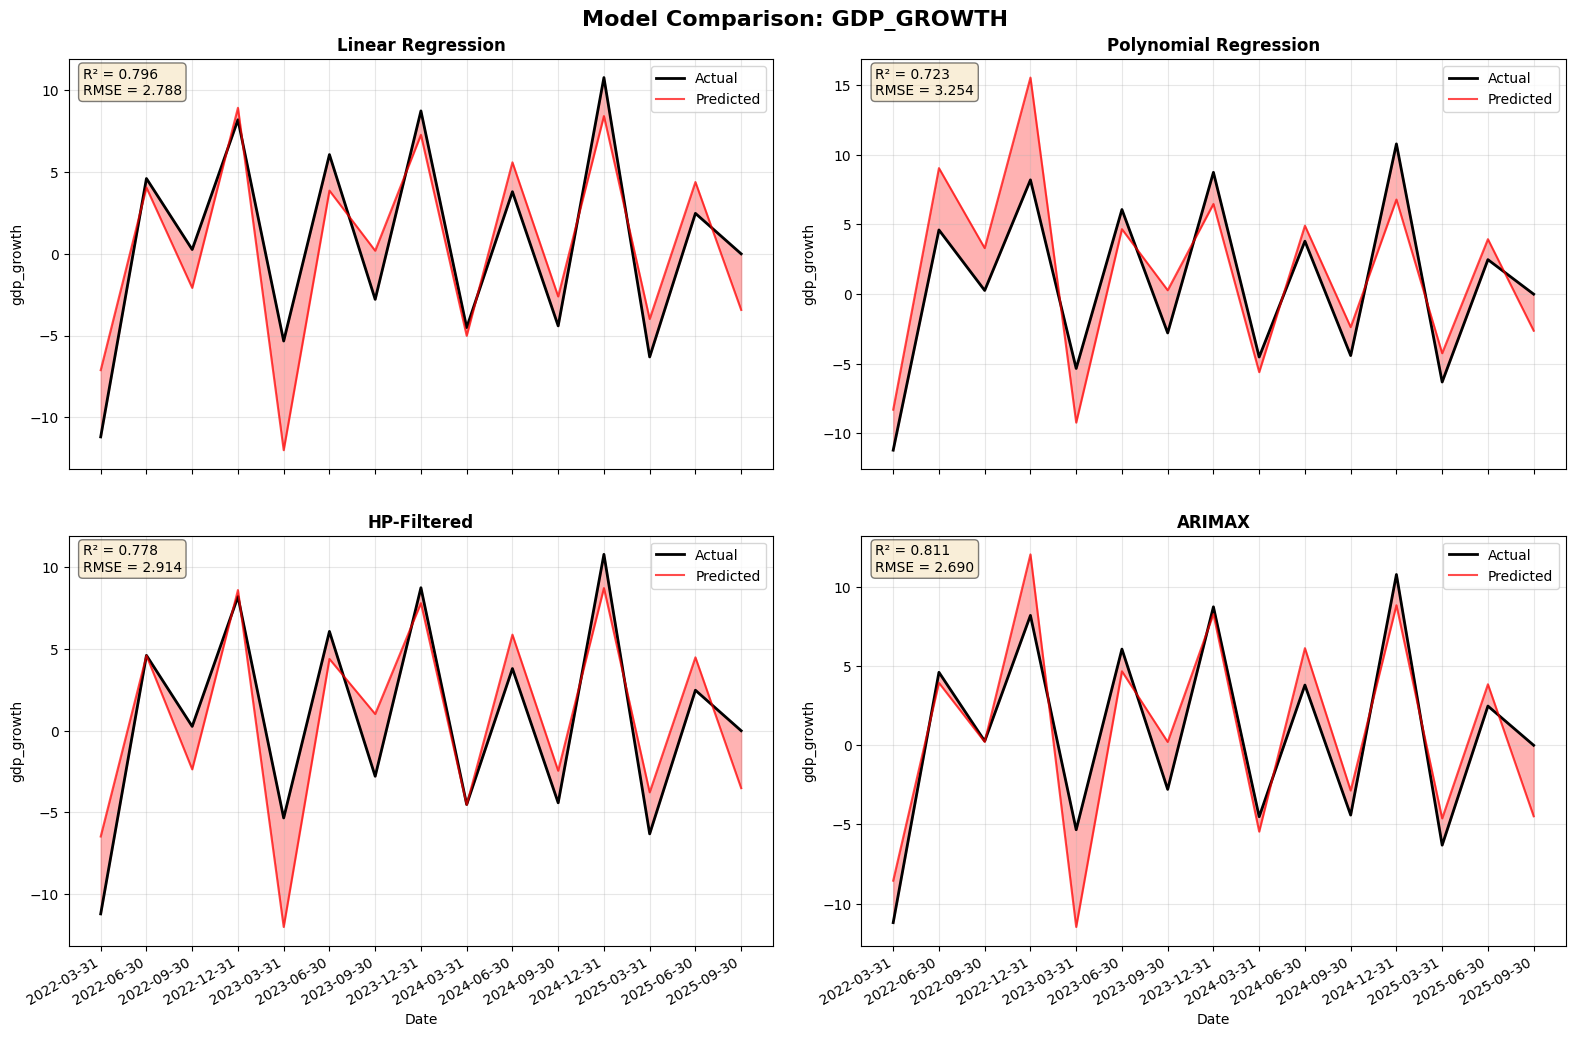



################################################################################
# PROCESSING TARGET: INFLATION
################################################################################

TRAINING ALL MODELS FOR: INFLATION

Training set: 88 observations
Test set: 15 observations
Predictors: 2

MODEL 1: MULTIPLE LINEAR REGRESSION - INFLATION

Training Performance:
  R² = 0.0079
  RMSE = 1.4583
  MAE = 1.1703
  MAPE = 253.7142%

Test Performance:
  R² = -0.4264
  RMSE = 3.1675
  MAE = 2.0403
  MAPE = 38.8343%

Model Coefficients:
        Feature  Coefficient
 inflation_lag4     0.045167
gdp_growth_lag1     0.018380

MODEL 2: POLYNOMIAL REGRESSION (degree=2) - INFLATION

Original features: 2
Polynomial features: 5

Training Performance:
  R² = 0.0752
  RMSE = 1.4079
  MAE = 1.1481
  MAPE = 265.0843%

Test Performance:
  R² = -1.1256
  RMSE = 3.8667
  MAE = 2.8584
  MAPE = 68.6932%

MODEL 3: HP-FILTERED REGRESSION (λ=1600) - INFLATION

Applying HP filter to target variable...
Apply

c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


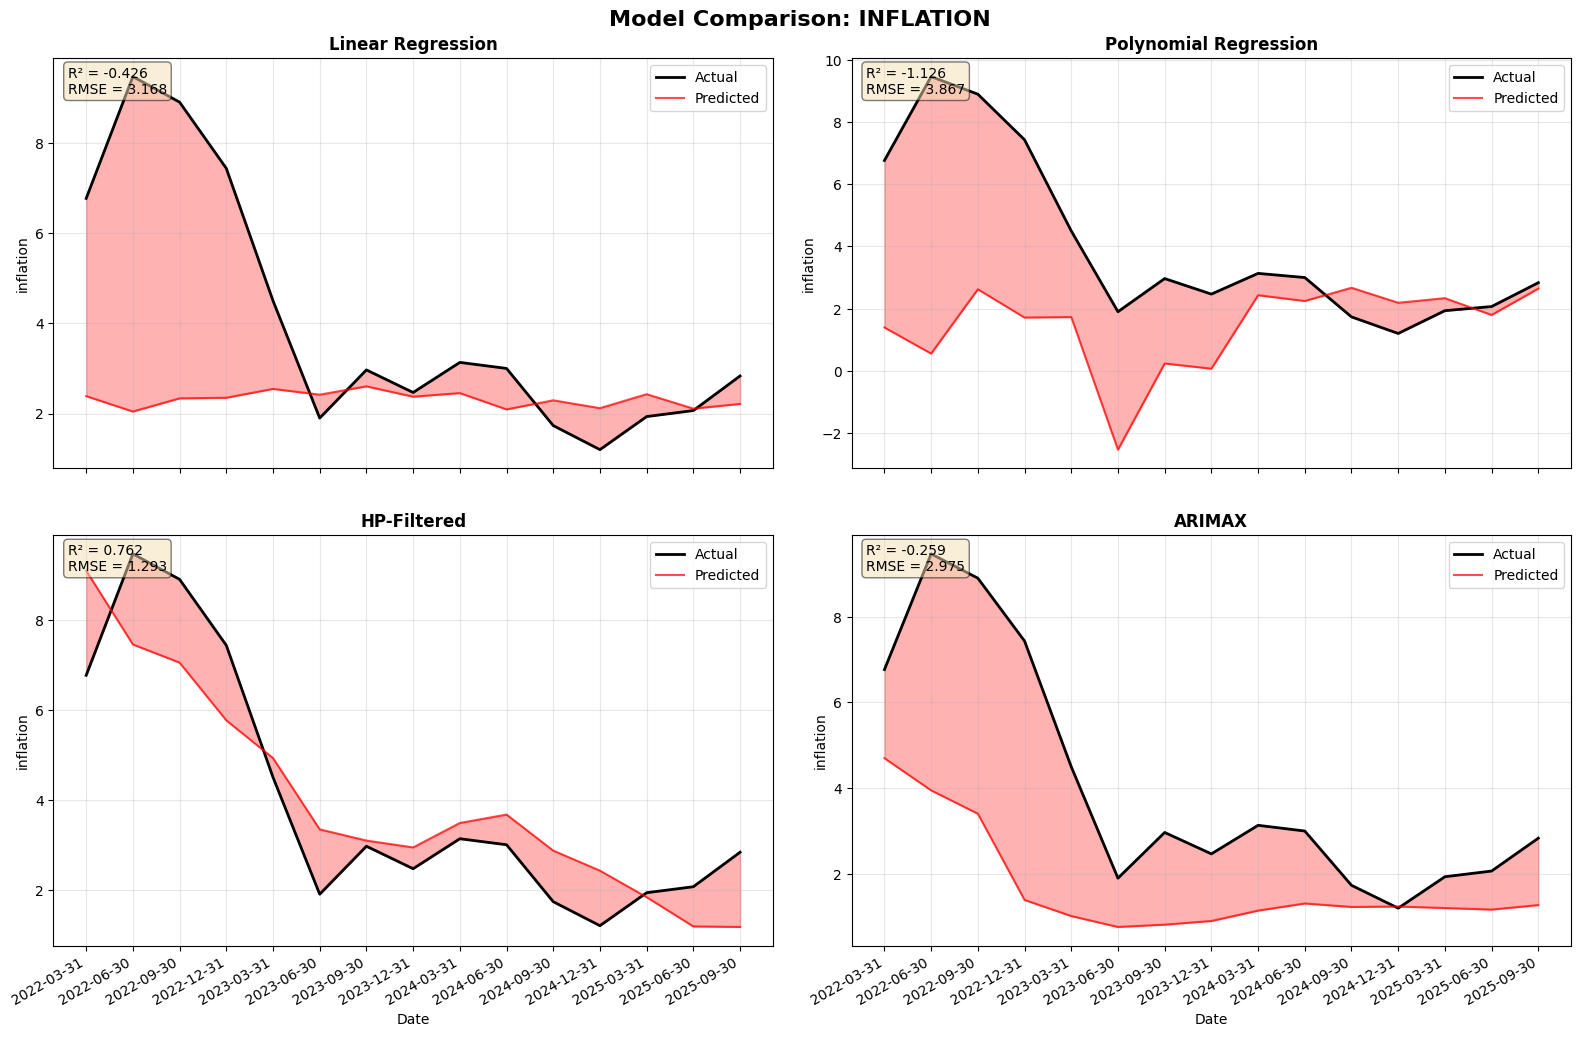



################################################################################
# PROCESSING TARGET: UNEMPLOYMENT
################################################################################

TRAINING ALL MODELS FOR: UNEMPLOYMENT

Training set: 88 observations
Test set: 15 observations
Predictors: 3

MODEL 1: MULTIPLE LINEAR REGRESSION - UNEMPLOYMENT

Training Performance:
  R² = 0.2261
  RMSE = 1.1431
  MAE = 0.8871
  MAPE = 25.8791%

Test Performance:
  R² = -3.5827
  RMSE = 1.7889
  MAE = 1.6490
  MAPE = 30.4609%

Model Coefficients:
        Feature  Coefficient
 inflation_lag1    -0.442386
gdp_growth_lag4     0.017079
gdp_growth_lag1     0.016884

MODEL 2: POLYNOMIAL REGRESSION (degree=2) - UNEMPLOYMENT

Original features: 3
Polynomial features: 9

Training Performance:
  R² = 0.3390
  RMSE = 1.0564
  MAE = 0.8137
  MAPE = 23.5423%

Test Performance:
  R² = -4.3710
  RMSE = 1.9367
  MAE = 1.7851
  MAPE = 32.9014%

MODEL 3: HP-FILTERED REGRESSION (λ=1600) - UNEMPLOYMENT

Appl

c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


✓ Model converged successfully

Training Performance:
  R² = 0.9069
  RMSE = 0.3965
  MAE = 0.2644
  MAPE = 6.0989%

Test Performance:
  R² = -3.5901
  RMSE = 1.7903
  MAE = 1.4851
  MAPE = nan%

Model AIC: 60.32
Model BIC: 77.17

MODEL COMPARISON: UNEMPLOYMENT

     Model  Train R²   Test R²  Train RMSE  Test RMSE  Train MAE  Test MAE  Test MAPE
    Linear  0.226080 -3.582674    1.143071   1.788894   0.887105  1.648980  30.460888
Polynomial  0.339020 -4.370996    1.056378   1.936657   0.813722  1.785111  32.901380
 Hp Filter  0.868023  0.881739    0.472035   0.287373   0.367153  0.233497   4.305328
    Arimax  0.906862 -3.590110    0.396541   1.790345   0.264384  1.485123        NaN

BEST MODELS:
  Highest Test R²: Hp Filter (R² = 0.8817)
  Lowest Test RMSE: Hp Filter (RMSE = 0.2874)


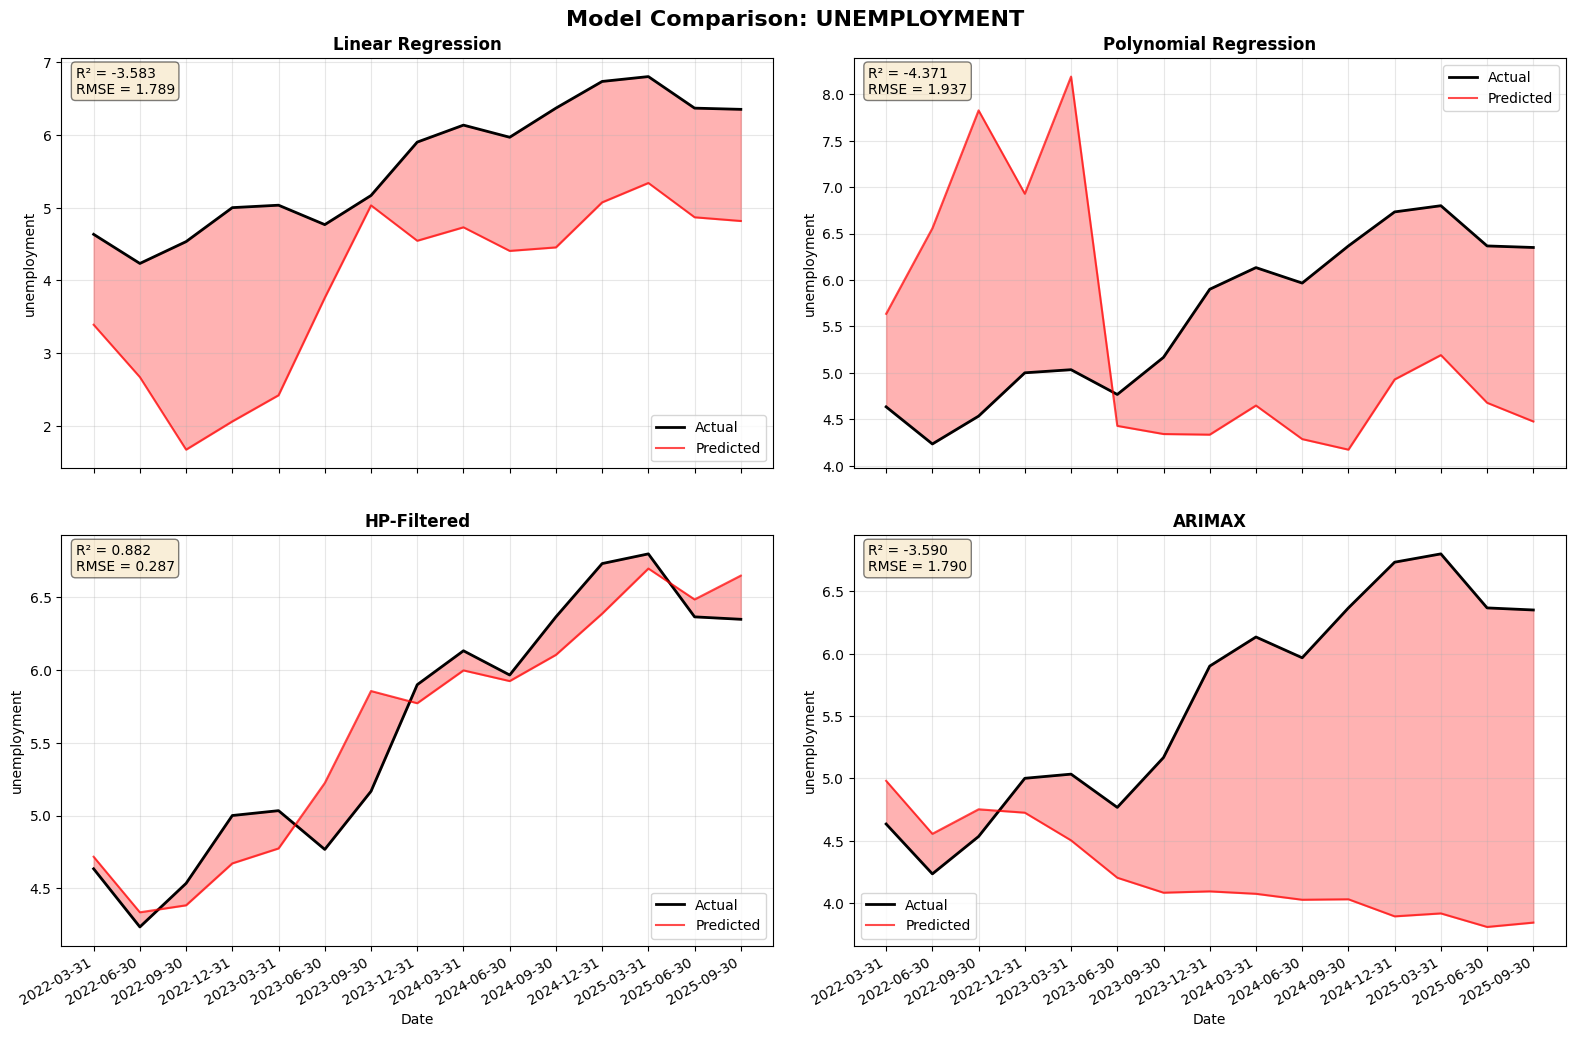

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def calculate_metrics(y_true, y_pred, model_name="Model"):
    """
    Calculate comprehensive evaluation metrics.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # MAPE (handle zero values)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if (y_true != 0).all() else np.nan
    
    # Adjusted R² (if we know n and p)
    n = len(y_true)
    
    return {
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }


def plot_predictions(y_train, y_test, y_pred_train, y_pred_test, dates_train, dates_test, 
                     target_name, model_name):
    """
    Plot actual vs predicted values for train and test sets.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Training set
    ax1.plot(dates_train, y_train, label='Actual', color='black', linewidth=2)
    ax1.plot(dates_train, y_pred_train, label='Predicted', color='blue', linewidth=1.5, alpha=0.7)
    ax1.fill_between(dates_train, y_train, y_pred_train, alpha=0.3, color='blue')
    ax1.set_title(f'{model_name} - Training Set: {target_name.upper()}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(target_name)
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Test set
    ax2.plot(dates_test, y_test, label='Actual', color='black', linewidth=2)
    ax2.plot(dates_test, y_pred_test, label='Predicted', color='red', linewidth=1.5, alpha=0.7)
    ax2.fill_between(dates_test, y_test, y_pred_test, alpha=0.3, color='red')
    ax2.set_title(f'{model_name} - Test Set: {target_name.upper()}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel(target_name)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig


# ============================================================================
# MODEL 1: MULTIPLE LINEAR REGRESSION
# ============================================================================

def train_linear_regression(X_train, y_train, X_test, y_test, target_name):
    """
    Train and evaluate Multiple Linear Regression model.
    """
    print(f"\n{'='*80}")
    print(f"MODEL 1: MULTIPLE LINEAR REGRESSION - {target_name.upper()}")
    print(f"{'='*80}")
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    train_metrics = calculate_metrics(y_train, y_pred_train, "Linear Regression (Train)")
    test_metrics = calculate_metrics(y_test, y_pred_test, "Linear Regression (Test)")
    
    print("\nTraining Performance:")
    print(f"  R² = {train_metrics['R²']:.4f}")
    print(f"  RMSE = {train_metrics['RMSE']:.4f}")
    print(f"  MAE = {train_metrics['MAE']:.4f}")
    print(f"  MAPE = {train_metrics['MAPE']:.4f}%")
    
    print("\nTest Performance:")
    print(f"  R² = {test_metrics['R²']:.4f}")
    print(f"  RMSE = {test_metrics['RMSE']:.4f}")
    print(f"  MAE = {test_metrics['MAE']:.4f}")
    print(f"  MAPE = {test_metrics['MAPE']:.4f}%")
    
    # Coefficients
    print("\nModel Coefficients:")
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=False)
    print(coef_df.to_string(index=False))
    
    return {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'coefficients': coef_df
    }


# ============================================================================
# MODEL 2: POLYNOMIAL REGRESSION
# ============================================================================

def train_polynomial_regression(X_train, y_train, X_test, y_test, target_name, degree=2):
    """
    Train and evaluate Polynomial Regression model.
    """
    print(f"\n{'='*80}")
    print(f"MODEL 2: POLYNOMIAL REGRESSION (degree={degree}) - {target_name.upper()}")
    print(f"{'='*80}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    print(f"\nOriginal features: {X_train.shape[1]}")
    print(f"Polynomial features: {X_train_poly.shape[1]}")
    
    # Standardize (important for polynomial features)
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly_scaled, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_poly_scaled)
    y_pred_test = model.predict(X_test_poly_scaled)
    
    # Metrics
    train_metrics = calculate_metrics(y_train, y_pred_train, f"Polynomial (degree={degree}, Train)")
    test_metrics = calculate_metrics(y_test, y_pred_test, f"Polynomial (degree={degree}, Test)")
    
    print("\nTraining Performance:")
    print(f"  R² = {train_metrics['R²']:.4f}")
    print(f"  RMSE = {train_metrics['RMSE']:.4f}")
    print(f"  MAE = {train_metrics['MAE']:.4f}")
    print(f"  MAPE = {train_metrics['MAPE']:.4f}%")
    
    print("\nTest Performance:")
    print(f"  R² = {test_metrics['R²']:.4f}")
    print(f"  RMSE = {test_metrics['RMSE']:.4f}")
    print(f"  MAE = {test_metrics['MAE']:.4f}")
    print(f"  MAPE = {test_metrics['MAPE']:.4f}%")
    
    return {
        'model': model,
        'poly': poly,
        'scaler': scaler,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }


# ============================================================================
# MODEL 3: HP-FILTERED REGRESSION
# ============================================================================

def train_hp_filter_regression(X_train, y_train, X_test, y_test, target_name, lamb=1600):
    """
    Train and evaluate HP-Filtered Regression model.
    """
    print(f"\n{'='*80}")
    print(f"MODEL 3: HP-FILTERED REGRESSION (λ={lamb}) - {target_name.upper()}")
    print(f"{'='*80}")
    
    # Apply HP filter to target
    print("\nApplying HP filter to target variable...")
    y_train_cycle, y_train_trend = hpfilter(y_train, lamb=lamb)
    y_test_cycle, y_test_trend = hpfilter(y_test, lamb=lamb)
    
    # Apply HP filter to predictors
    print("Applying HP filter to predictors...")
    X_train_cycle = pd.DataFrame(index=X_train.index, columns=X_train.columns)
    X_test_cycle = pd.DataFrame(index=X_test.index, columns=X_test.columns)
    
    for col in X_train.columns:
        try:
            cycle_train, _ = hpfilter(X_train[col], lamb=lamb)
            cycle_test, _ = hpfilter(X_test[col], lamb=lamb)
            X_train_cycle[col] = cycle_train
            X_test_cycle[col] = cycle_test
        except:
            print(f"  ⚠️  Could not filter {col}, using original values")
            X_train_cycle[col] = X_train[col]
            X_test_cycle[col] = X_test[col]
    
    # Train model on cyclical components
    model = LinearRegression()
    model.fit(X_train_cycle, y_train_cycle)
    
    # Predictions (cyclical components)
    y_pred_train_cycle = model.predict(X_train_cycle)
    y_pred_test_cycle = model.predict(X_test_cycle)
    
    # Add trend back to get final predictions
    y_pred_train = y_pred_train_cycle + y_train_trend
    y_pred_test = y_pred_test_cycle + y_test_trend
    
    # Metrics
    train_metrics = calculate_metrics(y_train, y_pred_train, "HP-Filtered (Train)")
    test_metrics = calculate_metrics(y_test, y_pred_test, "HP-Filtered (Test)")
    
    print("\nTraining Performance:")
    print(f"  R² = {train_metrics['R²']:.4f}")
    print(f"  RMSE = {train_metrics['RMSE']:.4f}")
    print(f"  MAE = {train_metrics['MAE']:.4f}")
    print(f"  MAPE = {train_metrics['MAPE']:.4f}%")
    
    print("\nTest Performance:")
    print(f"  R² = {test_metrics['R²']:.4f}")
    print(f"  RMSE = {test_metrics['RMSE']:.4f}")
    print(f"  MAE = {test_metrics['MAE']:.4f}")
    print(f"  MAPE = {test_metrics['MAPE']:.4f}%")
    
    return {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'y_train_cycle': y_train_cycle,
        'y_test_cycle': y_test_cycle,
        'y_train_trend': y_train_trend,
        'y_test_trend': y_test_trend
    }


# ============================================================================
# MODEL 4: ARIMAX
# ============================================================================

def train_arimax(X_train, y_train, X_test, y_test, target_name, order=(1,0,1), seasonal_order=(0,0,1,4)):
    """
    Train and evaluate ARIMAX model.
    """
    print(f"\n{'='*80}")
    print(f"MODEL 4: ARIMAX{order}x{seasonal_order} - {target_name.upper()}")
    print(f"{'='*80}")
    
    try:
        # Train ARIMAX model
        print(f"\nFitting ARIMAX{order}x{seasonal_order}...")
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False, maxiter=200)
        
        print("✓ Model converged successfully")
        
        # Predictions
        y_pred_train = results.fittedvalues
        y_pred_test = results.forecast(steps=len(y_test), exog=X_test)
        
        # Metrics
        train_metrics = calculate_metrics(y_train, y_pred_train, f"ARIMAX{order} (Train)")
        test_metrics = calculate_metrics(y_test, y_pred_test, f"ARIMAX{order} (Test)")
        
        print("\nTraining Performance:")
        print(f"  R² = {train_metrics['R²']:.4f}")
        print(f"  RMSE = {train_metrics['RMSE']:.4f}")
        print(f"  MAE = {train_metrics['MAE']:.4f}")
        print(f"  MAPE = {train_metrics['MAPE']:.4f}%")
        
        print("\nTest Performance:")
        print(f"  R² = {test_metrics['R²']:.4f}")
        print(f"  RMSE = {test_metrics['RMSE']:.4f}")
        print(f"  MAE = {test_metrics['MAE']:.4f}")
        print(f"  MAPE = {test_metrics['MAPE']:.4f}%")
        
        print(f"\nModel AIC: {results.aic:.2f}")
        print(f"Model BIC: {results.bic:.2f}")
        
        return {
            'model': results,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'y_pred_train': y_pred_train,
            'y_pred_test': y_pred_test,
            'aic': results.aic,
            'bic': results.bic
        }
        
    except Exception as e:
        print(f"\n❌ ARIMAX model failed to converge: {e}")
        print("Returning None - will be excluded from comparison")
        return None


# ============================================================================
# MAIN TRAINING FUNCTION
# ============================================================================

def train_all_models(X_train, y_train, X_test, y_test, dates_train, dates_test, target_name):
    """
    Train all 4 models for a given target variable.
    """
    print("\n" + "="*80)
    print(f"TRAINING ALL MODELS FOR: {target_name.upper()}")
    print("="*80)
    print(f"\nTraining set: {len(X_train)} observations")
    print(f"Test set: {len(X_test)} observations")
    print(f"Predictors: {X_train.shape[1]}")
    
    results = {}
    
    # Model 1: Linear Regression
    results['linear'] = train_linear_regression(X_train, y_train, X_test, y_test, target_name)
    
    # Model 2: Polynomial Regression
    results['polynomial'] = train_polynomial_regression(X_train, y_train, X_test, y_test, target_name, degree=2)
    
    # Model 3: HP-Filtered
    results['hp_filter'] = train_hp_filter_regression(X_train, y_train, X_test, y_test, target_name, lamb=1600)
    
    # Model 4: ARIMAX
    results['arimax'] = train_arimax(X_train, y_train, X_test, y_test, target_name, 
                                      order=(1,0,1), seasonal_order=(0,0,1,4))
    
    return results


# ============================================================================
# MODEL COMPARISON
# ============================================================================

def compare_models(results, target_name):
    """
    Compare all models and create summary table.
    """
    print(f"\n{'='*80}")
    print(f"MODEL COMPARISON: {target_name.upper()}")
    print(f"{'='*80}")
    
    comparison_data = []
    
    for model_name, result in results.items():
        if result is not None:  # Skip failed models
            comparison_data.append({
                'Model': model_name.replace('_', ' ').title(),
                'Train R²': result['train_metrics']['R²'],
                'Test R²': result['test_metrics']['R²'],
                'Train RMSE': result['train_metrics']['RMSE'],
                'Test RMSE': result['test_metrics']['RMSE'],
                'Train MAE': result['train_metrics']['MAE'],
                'Test MAE': result['test_metrics']['MAE'],
                'Test MAPE': result['test_metrics']['MAPE']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n" + comparison_df.to_string(index=False))
    
    # Find best model
    best_model_by_r2 = comparison_df.loc[comparison_df['Test R²'].idxmax(), 'Model']
    best_model_by_rmse = comparison_df.loc[comparison_df['Test RMSE'].idxmin(), 'Model']
    
    print(f"\n{'='*80}")
    print("BEST MODELS:")
    print(f"{'='*80}")
    print(f"  Highest Test R²: {best_model_by_r2} (R² = {comparison_df['Test R²'].max():.4f})")
    print(f"  Lowest Test RMSE: {best_model_by_rmse} (RMSE = {comparison_df['Test RMSE'].min():.4f})")
    
    return comparison_df


def plot_model_comparison(results, y_train, y_test, dates_train, dates_test, target_name):
    """
    Create comprehensive comparison plots.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Model Comparison: {target_name.upper()}', fontsize=16, fontweight='bold')
    
    model_names = ['linear', 'polynomial', 'hp_filter', 'arimax']
    titles = ['Linear Regression', 'Polynomial Regression', 'HP-Filtered', 'ARIMAX']
    
    for idx, (model_key, title) in enumerate(zip(model_names, titles)):
        ax = axes[idx // 2, idx % 2]
        
        if model_key in results and results[model_key] is not None:
            result = results[model_key]
            
            # Plot test set predictions
            ax.plot(dates_test, y_test, label='Actual', color='black', linewidth=2)
            ax.plot(dates_test, result['y_pred_test'], label='Predicted', 
                   color='red', linewidth=1.5, alpha=0.7)
            ax.fill_between(dates_test, y_test, result['y_pred_test'], alpha=0.3, color='red')
            
            # Add metrics to plot
            r2 = result['test_metrics']['R²']
            rmse = result['test_metrics']['RMSE']
            ax.text(0.02, 0.98, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}', 
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel('Date')
            ax.set_ylabel(target_name)
            ax.legend()
            ax.grid(alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Model Failed', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(title, fontweight='bold')
    
    plt.tight_layout()
    return fig


# ============================================================================
# MAIN EXECUTION
# ============================================================================


print("="*80)
print("PHASE 2: MODEL TRAINING & EVALUATION")
print("="*80)

targets = ['gdp_growth', 'inflation', 'unemployment']
all_results = {}
all_comparisons = {}

for target in targets:
    print(f"\n\n{'#'*80}")
    print(f"# PROCESSING TARGET: {target.upper()}")
    print(f"{'#'*80}")

    # Load data
    X_train = cleaned_data[target]['X_train']
    y_train = cleaned_data[target]['y_train']
    X_test = cleaned_data[target]['X_test']
    y_test = cleaned_data[target]['y_test']
    dates_train = pd.read_csv(f'gen_files/train_{target}.csv')['Date']
    dates_test = pd.read_csv(f'gen_files/test_{target}.csv')['Date']

    # Train all models
    results = train_all_models(X_train, y_train, X_test, y_test, 
                                dates_train, dates_test, target)

    # Compare models
    comparison_df = compare_models(results, target)

    # Create comparison plots
    fig = plot_model_comparison(results, y_train, y_test, 
                                dates_train, dates_test, target)
    fig.autofmt_xdate()
    # fig.savefig(f'model_comparison_{target}.png', dpi=300, bbox_inches='tight')
    # print(f"\n✓ Saved: model_comparison_{target}.png")
    plt.show()
    plt.close()

    # Store results
    all_results[target] = results
    all_comparisons[target] = comparison_df

    # # Save comparison table
    # comparison_df.to_csv(f'model_comparison_{target}.csv', index=False)
    # print(f"✓ Saved: model_comparison_{target}.csv")

## Model Interpretation & Refinement

### Coefficient Interpretation

In [ ]:

import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter

def interpret_coefficient(param, coef, pval, tstat, target_name):
    """
    Provide detailed economic interpretation for a single coefficient.
    """
    # Significance markers
    if pval < 0.01:
        sig_text = "HIGHLY SIGNIFICANT (p < 0.01)"
        sig_marker = "***"
    elif pval < 0.05:
        sig_text = "SIGNIFICANT (p < 0.05)"
        sig_marker = "**"
    elif pval < 0.10:
        sig_text = "WEAKLY SIGNIFICANT (p < 0.10)"
        sig_marker = "*"
    else:
        sig_text = "NOT SIGNIFICANT (p > 0.10)"
        sig_marker = ""
    
    direction = "increases" if coef > 0 else "decreases"
    
    interpretation = {
        'parameter': param,
        'coefficient': f"{coef:.4f}{sig_marker}",
        'direction': direction,
        'magnitude': abs(coef),
        'significance': sig_text,
        'p_value': pval,
        't_statistic': tstat
    }
    
    # Economic context based on variable type
    if 'inflation' in param.lower():
        if 'lag' in param.lower():
            if coef > 0:
                interpretation['economic_context'] = "Inflation persistence - past inflation creates adaptive expectations that influence current inflation"
            else:
                interpretation['economic_context'] = "Inflation correction mechanism - economy adjusts after inflationary periods"
        else:
            if coef < 0 and 'gdp' in target_name.lower():
                interpretation['economic_context'] = "Cost-push effects - higher inflation reduces real purchasing power and dampens growth"
            elif coef > 0 and 'unemployment' in target_name.lower():
                interpretation['economic_context'] = "Phillips Curve relationship - inflation and unemployment tradeoff"
    
    elif 'gdp' in param.lower() or 'growth' in param.lower():
        if coef > 0:
            interpretation['economic_context'] = "Procyclical relationship - economic expansion drives demand and activity"
        else:
            interpretation['economic_context'] = "Countercyclical adjustment - growth slowdowns trigger economic responses"
    
    elif 'unemployment' in param.lower():
        if coef < 0 and 'gdp' in target_name.lower():
            interpretation['economic_context'] = "Okun's Law - inverse relationship between unemployment and economic growth"
        elif coef > 0 and 'inflation' in target_name.lower():
            interpretation['economic_context'] = "Phillips Curve - labor market tightness affects wage pressures and inflation"
    
    else:
        interpretation['economic_context'] = "Empirical relationship specific to Luxembourg's economic structure"
    
    return interpretation


def analyze_arimax_coefficients(arimax_model, target_name):
    """
    Extract and interpret ARIMAX model coefficients.
    """
    print("\n" + "="*80)
    print(f"ARIMAX MODEL - COEFFICIENT ANALYSIS: {target_name.upper()}")
    print("="*80)
    
    # Extract coefficient details
    coef_df = pd.DataFrame({
        'Parameter': arimax_model.params.index,
        'Coefficient': arimax_model.params.values,
        'Std Error': arimax_model.bse.values,
        'T-statistic': arimax_model.tvalues.values,
        'P-value': arimax_model.pvalues.values,
        'CI Lower (95%)': arimax_model.conf_int()[0].values,
        'CI Upper (95%)': arimax_model.conf_int()[1].values
    })
    
    # Add significance markers
    coef_df['Sig'] = coef_df['P-value'].apply(
        lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
    )
    
    print("\n" + "-"*80)
    print("COMPLETE COEFFICIENT TABLE")
    print("-"*80)
    print(coef_df.to_string(index=False))
    
    # Separate exogenous variables from AR/MA/technical terms
    exog_params = coef_df[~coef_df['Parameter'].str.contains('ar.|ma.|sigma2|intercept', na=False)]
    technical_params = coef_df[coef_df['Parameter'].str.contains('ar.|ma.|sigma2|intercept', na=False)]
    
    # Interpret exogenous variables
    if len(exog_params) > 0:
        print("\n" + "-"*80)
        print("EXOGENOUS VARIABLES - ECONOMIC INTERPRETATION")
        print("-"*80)
        
        interpretations = []
        for _, row in exog_params.iterrows():
            interp = interpret_coefficient(
                row['Parameter'], row['Coefficient'], 
                row['P-value'], row['T-statistic'], target_name
            )
            interpretations.append(interp)
            
            print(f"\n{row['Parameter']}: {interp['coefficient']}")
            print(f"  • Coefficient: {row['Coefficient']:.4f}")
            print(f"  • Std Error: {row['Std Error']:.4f}")
            print(f"  • T-statistic: {row['T-statistic']:.3f}")
            print(f"  • P-value: {row['P-value']:.4f}")
            print(f"  • Significance: {interp['significance']}")
            print(f"  • 95% CI: [{row['CI Lower (95%)']:.4f}, {row['CI Upper (95%)']:.4f}]")
            print(f"\n  → Interpretation:")
            print(f"    A 1-unit increase in {row['Parameter']} {interp['direction']}")
            print(f"    {target_name} by {interp['magnitude']:.4f} units (ceteris paribus)")
            print(f"\n  → Economic Context:")
            print(f"    {interp['economic_context']}")
    
    # Note about technical parameters
    if len(technical_params) > 0:
        print("\n" + "-"*80)
        print("TECHNICAL PARAMETERS (AR/MA TERMS)")
        print("-"*80)
        print("These capture time series dynamics and autocorrelation patterns,")
        print("not direct economic relationships.")
        print("\n" + technical_params[['Parameter', 'Coefficient', 'P-value', 'Sig']].to_string(index=False))
    
    # Model diagnostics
    print("\n" + "-"*80)
    print("MODEL DIAGNOSTICS")
    print("-"*80)
    print(f"AIC: {arimax_model.aic:.2f}")
    print(f"BIC: {arimax_model.bic:.2f}")
    print(f"Log-Likelihood: {arimax_model.llf:.2f}")
    
    # Full summary
    print("\n" + "="*80)
    print("FULL ARIMAX SUMMARY")
    print("="*80)
    print(arimax_model.summary())
    
    return coef_df, exog_params if len(exog_params) > 0 else None


def analyze_hp_filter_coefficients(X_train, y_train, target_name, lamb=1600):
    """
    Extract and interpret HP-Filtered regression coefficients.
    Requires original training data to recompute cyclical components.
    """
    print("\n" + "="*80)
    print(f"HP-FILTERED REGRESSION - COEFFICIENT ANALYSIS: {target_name.upper()}")
    print("="*80)
    
    # Apply HP filter to target
    print("\nRecomputing HP filter for coefficient analysis...")
    y_train_cycle, _ = hpfilter(y_train, lamb=lamb)
    
    # Apply HP filter to predictors
    X_train_cycle = pd.DataFrame(index=X_train.index, columns=X_train.columns)
    for col in X_train.columns:
        try:
            cycle, _ = hpfilter(X_train[col], lamb=lamb)
            X_train_cycle[col] = cycle
        except:
            print(f"  ⚠️  Could not filter {col}, using original values")
            X_train_cycle[col] = X_train[col]
    
    # Fit OLS with statsmodels
    X_train_cycle_sm = sm.add_constant(X_train_cycle)
    model = sm.OLS(y_train_cycle, X_train_cycle_sm).fit()
    
    # Extract coefficient details
    coef_df = pd.DataFrame({
        'Parameter': model.params.index,
        'Coefficient': model.params.values,
        'Std Error': model.bse.values,
        'T-statistic': model.tvalues.values,
        'P-value': model.pvalues.values,
        'CI Lower (95%)': model.conf_int()[0].values,
        'CI Upper (95%)': model.conf_int()[1].values
    })
    
    # Add significance markers
    coef_df['Sig'] = coef_df['P-value'].apply(
        lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
    )
    
    print("\n" + "-"*80)
    print("COMPLETE COEFFICIENT TABLE (CYCLICAL COMPONENTS)")
    print("-"*80)
    print(coef_df.to_string(index=False))
    
    print("\n" + "-"*80)
    print("IMPORTANT NOTE ABOUT HP-FILTER COEFFICIENTS")
    print("-"*80)
    print("• These coefficients apply to CYCLICAL components only")
    print("• They measure short-term deviations from long-term trends")
    print("• Interpretation: relationship between business cycle fluctuations")
    print("-"*80)
    
    # Interpret predictors (exclude constant)
    predictor_params = coef_df[coef_df['Parameter'] != 'const']
    
    if len(predictor_params) > 0:
        print("\n" + "-"*80)
        print("PREDICTOR VARIABLES - CYCLICAL INTERPRETATION")
        print("-"*80)
        
        interpretations = []
        for _, row in predictor_params.iterrows():
            interp = interpret_coefficient(
                row['Parameter'], row['Coefficient'], 
                row['P-value'], row['T-statistic'], 
                target_name + " (cyclical)"
            )
            interpretations.append(interp)
            
            print(f"\n{row['Parameter']}: {interp['coefficient']}")
            print(f"  • Coefficient: {row['Coefficient']:.4f}")
            print(f"  • Std Error: {row['Std Error']:.4f}")
            print(f"  • T-statistic: {row['T-statistic']:.3f}")
            print(f"  • P-value: {row['P-value']:.4f}")
            print(f"  • Significance: {interp['significance']}")
            print(f"  • 95% CI: [{row['CI Lower (95%)']:.4f}, {row['CI Upper (95%)']:.4f}]")
            print(f"\n  → Cyclical Interpretation:")
            print(f"    A 1-unit increase in the cyclical component of {row['Parameter']}")
            print(f"    {interp['direction']} the cyclical component of {target_name}")
            print(f"    by {interp['magnitude']:.4f} units")
            print(f"\n  → Economic Context:")
            print(f"    {interp['economic_context']}")
            print(f"    This captures how business cycle fluctuations propagate")
    
    # Model diagnostics
    print("\n" + "-"*80)
    print("MODEL DIAGNOSTICS")
    print("-"*80)
    print(f"R-squared (cyclical): {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.2f}")
    print(f"Prob (F-statistic): {model.f_pvalue:.4e}")
    
    # Full summary
    print("\n" + "="*80)
    print("FULL OLS SUMMARY (CYCLICAL COMPONENTS)")
    print("="*80)
    print(model.summary())
    
    return coef_df, predictor_params


def create_coefficient_summary_table(all_results, best_models, cleaned_data):
    """
    Create a comprehensive summary table of all best model coefficients.
    
    Parameters:
    -----------
    all_results : dict
        Results from Phase 2 model training
    best_models : dict
        Dictionary mapping target -> (model_key, model_name)
    cleaned_data : dict
        Original data dictionary containing X_train and y_train for each target
    """
    print("\n\n" + "#"*80)
    print("# COMPREHENSIVE COEFFICIENT SUMMARY - ALL BEST MODELS")
    print("#"*80)
    
    summary_data = []
    
    for target, (model_key, model_name) in best_models.items():
        print(f"\nProcessing {target.upper()} - {model_name}...")
        
        result = all_results[target][model_key]
        
        if result is None:
            print(f"  ⚠️  Skipping {target} - model failed")
            continue
        
        # Get coefficients based on model type
        if model_key == 'arimax':
            coef_df, exog_params = analyze_arimax_coefficients(result['model'], target)
            if exog_params is not None:
                for _, row in exog_params.iterrows():
                    summary_data.append({
                        'Target': target.upper(),
                        'Model': model_name,
                        'Predictor': row['Parameter'],
                        'Coefficient': f"{row['Coefficient']:.4f}",
                        'Std Error': f"{row['Std Error']:.4f}",
                        'T-statistic': f"{row['T-statistic']:.3f}",
                        'P-value': f"{row['P-value']:.4f}",
                        'Significance': row['Sig'],
                        'CI 95%': f"[{row['CI Lower (95%)']:.4f}, {row['CI Upper (95%)']:.4f}]"
                    })
        
        elif model_key == 'hp_filter':
            # Use original training data from cleaned_data
            X_train = cleaned_data[target]['X_train']
            y_train = cleaned_data[target]['y_train']
            
            coef_df, predictor_params = analyze_hp_filter_coefficients(
                X_train, y_train, target, lamb=1600
            )
            
            for _, row in predictor_params.iterrows():
                summary_data.append({
                    'Target': target.upper(),
                    'Model': model_name,
                    'Predictor': row['Parameter'],
                    'Coefficient': f"{row['Coefficient']:.4f}",
                    'Std Error': f"{row['Std Error']:.4f}",
                    'T-statistic': f"{row['T-statistic']:.3f}",
                    'P-value': f"{row['P-value']:.4f}",
                    'Significance': row['Sig'],
                    'CI 95%': f"[{row['CI Lower (95%)']:.4f}, {row['CI Upper (95%)']:.4f}]"
                })
    
    # Create and display summary table
    summary_df = pd.DataFrame(summary_data)
    
    print("\n\n" + "="*80)
    print("FINAL COEFFICIENT SUMMARY TABLE")
    print("="*80)
    print("\nLegend: *** p<0.01, ** p<0.05, * p<0.10")
    print("\n" + summary_df.to_string(index=False))
    
    return summary_df


# ============================================================================
# PHASE 3 MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    
    # Define best models
    best_models = {
        'gdp_growth': ('arimax', 'ARIMAX(1,0,1)x(0,0,1,4)'),
        'inflation': ('hp_filter', 'HP-Filtered Regression'),
        'unemployment': ('hp_filter', 'HP-Filtered Regression')
    }
    
    # Analyze each best model in detail
    coefficient_summary = create_coefficient_summary_table(
        all_results, 
        best_models, 
        cleaned_data
    )



################################################################################
# COMPREHENSIVE COEFFICIENT SUMMARY - ALL BEST MODELS
################################################################################

Processing GDP_GROWTH - ARIMAX(1,0,1)x(0,0,1,4)...

ARIMAX MODEL - COEFFICIENT ANALYSIS: GDP_GROWTH

--------------------------------------------------------------------------------
COMPLETE COEFFICIENT TABLE
--------------------------------------------------------------------------------
      Parameter  Coefficient  Std Error  T-statistic       P-value  CI Lower (95%)  CI Upper (95%) Sig
gdp_growth_lag1    -0.004208   0.024020    -0.175200  8.609224e-01       -0.051287        0.042870    
gdp_growth_lag4     1.010908   0.029761    33.967982 6.619768e-253        0.952578        1.069237 ***
 inflation_lag1    -0.008424   0.049911    -0.168782  8.659680e-01       -0.106247        0.089399    
          ar.L1    -0.515224   0.326677    -1.577167  1.147572e-01       -1.155

c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
c:\Users\admin\Documents\UTM-Master\EDA\ExploratoryDataAnalysis\.venv\Lib\site-packages\statsmodels\tsa\filters\hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix form

**GDP Growth:**
- **Dominated by quarterly momentum** - past GDP growth (lag 4) is the strongest predictor with a 1.01 coefficient, meaning growth patterns persist and slightly amplify over quarters
- **Inflation has no impact** - lagged inflation doesn't affect GDP growth in Luxembourg
- **Short-term dynamics are weak** - immediate past quarter (lag 1) shows no relationship

**Inflation**:
- **Self-correcting mechanism** - high inflation 4 quarters ago leads to lower inflation today (coefficient: -0.33), indicating mean-reversion
- **Decoupled from economic growth** - GDP growth doesn't drive inflation, suggesting Luxembourg's inflation is externally driven rather than demand-pull

**Unemployment**:
- **Phillips Curve confirmed** - higher inflation reduces unemployment (coefficient: -0.13), as expected from economic theory
- **Broken Okun's Law** - GDP growth slightly *increases* unemployment (coefficient: 0.02), contradicting traditional theory and reflecting Luxembourg's "jobless growth" with cross-border workers

---

 **Are results statistically significant?**

**YES, but selectively:**

Highly Significant (p < 0.01): ***
- GDP growth lag 4 → GDP growth (p < 0.0001)
- Inflation lag 4 → Inflation (p = 0.003)
- Inflation lag 1 → Unemployment (p = 0.006)

Weakly Significant (p < 0.10): *
- GDP growth lag 1 → Unemployment (p = 0.077)

NOT Significant (p > 0.10):
- GDP growth lag 1 → GDP growth (p = 0.86)
- Inflation lag 1 → GDP growth (p = 0.87)
- GDP growth lag 1 → Inflation (p = 0.61)
- GDP growth lag 4 → Unemployment (p = 0.21)


### Residual Analysis




ANALYZING: GDP_GROWTH - ARIMAX(1,0,1)x(0,0,1,4)

RESIDUAL ANALYSIS: ARIMAX(1,0,1)x(0,0,1,4) - GDP_GROWTH

--------------------------------------------------------------------------------
1. RESIDUAL DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------
Mean of residuals: -0.012553
Std of residuals: 2.5023
Min residual: -5.8226
Max residual: 7.0240
Skewness: -0.0103
Kurtosis: -0.0604

--------------------------------------------------------------------------------
2. NORMALITY TESTS
--------------------------------------------------------------------------------

Shapiro-Wilk Test:
  Statistic: 0.9944
  P-value: 0.9738
  ✓ PASS: Residuals are normally distributed (p > 0.05)

Jarque-Bera Test:
  Statistic: 0.0150
  P-value: 0.9925
  ✓ PASS: Residuals are normally distributed (p > 0.05)

Kolmogorov-Smirnov Test:
  Statistic: 0.0338
  P-value: 0.9999
  ✓ PASS: Residuals are normally distributed (p > 0.05)

--------------------------------

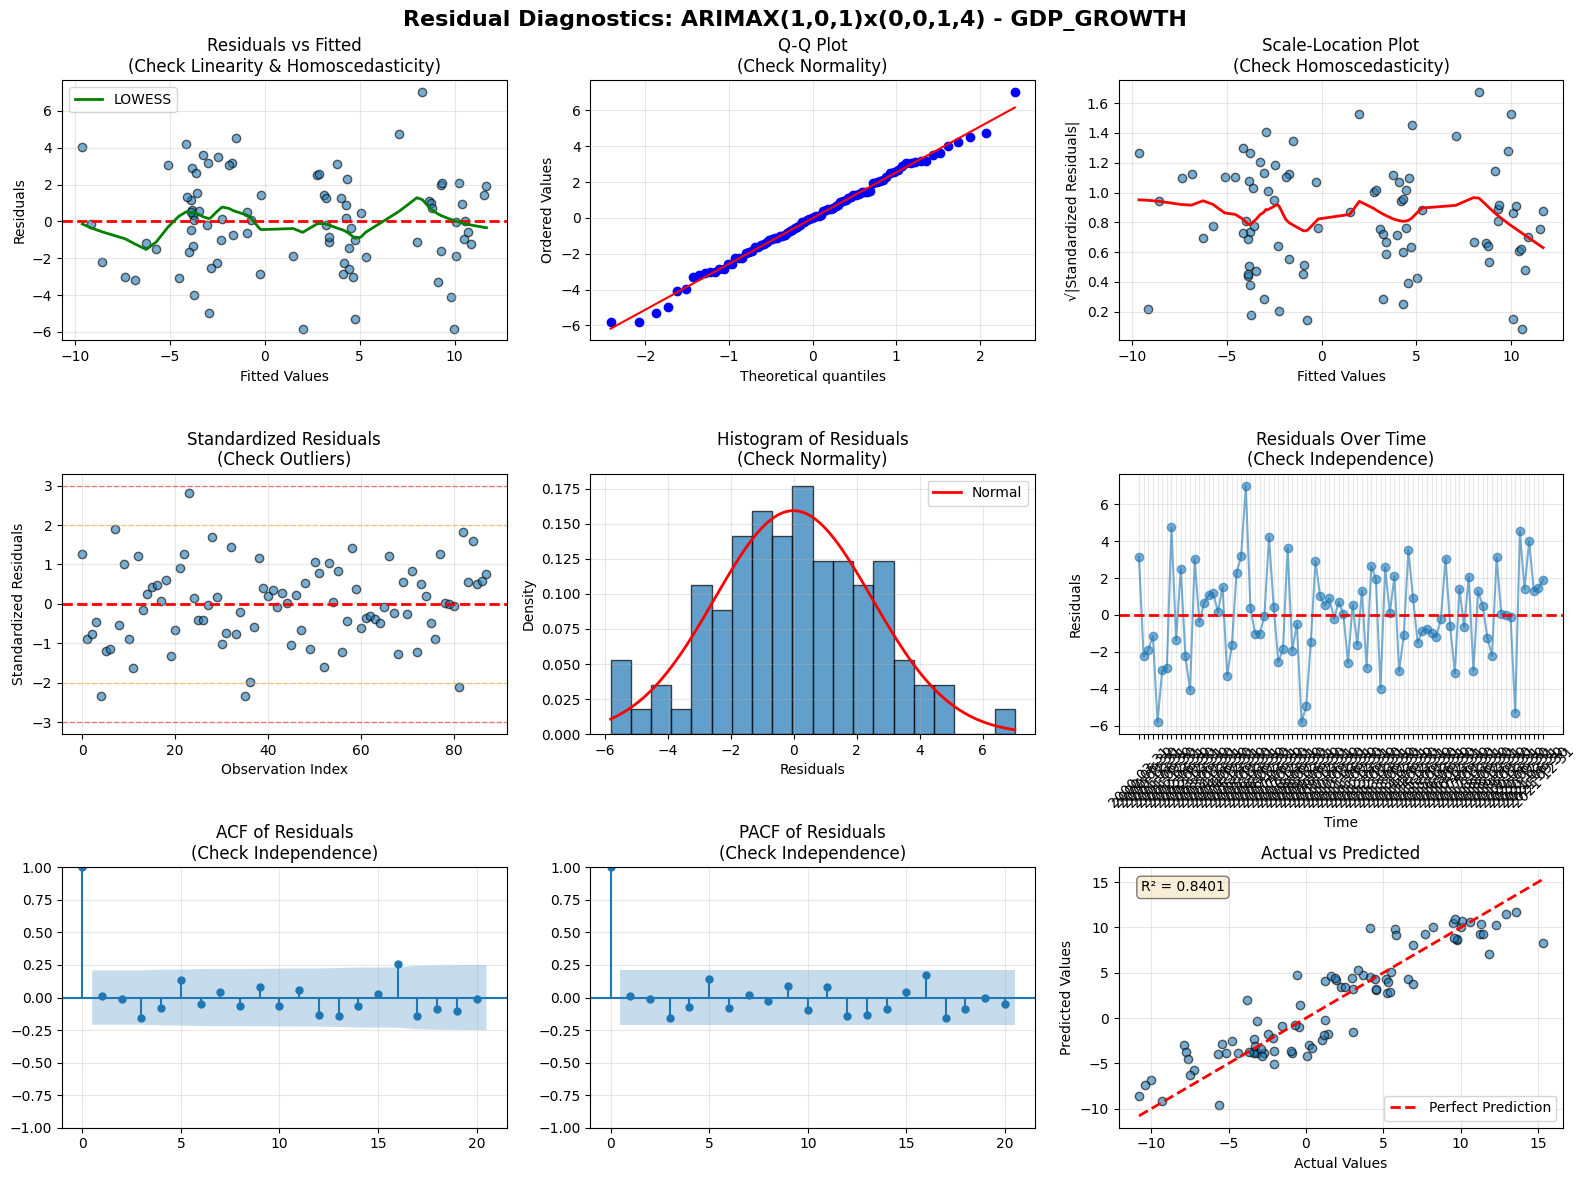



ANALYZING: INFLATION - HP-Filtered Regression

Note: Analyzing residuals of CYCLICAL components for HP-Filter model

RESIDUAL ANALYSIS: HP-Filtered Regression - INFLATION

--------------------------------------------------------------------------------
1. RESIDUAL DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------
Mean of residuals: -0.000000
Std of residuals: 1.1215
Min residual: -2.6047
Max residual: 2.7459
Skewness: -0.2534
Kurtosis: -0.3812

--------------------------------------------------------------------------------
2. NORMALITY TESTS
--------------------------------------------------------------------------------

Shapiro-Wilk Test:
  Statistic: 0.9835
  P-value: 0.3296
  ✓ PASS: Residuals are normally distributed (p > 0.05)

Jarque-Bera Test:
  Statistic: 1.4748
  P-value: 0.4784
  ✓ PASS: Residuals are normally distributed (p > 0.05)

Kolmogorov-Smirnov Test:
  Statistic: 0.0711
  P-value: 0.7377
  ✓ PASS: Residuals are

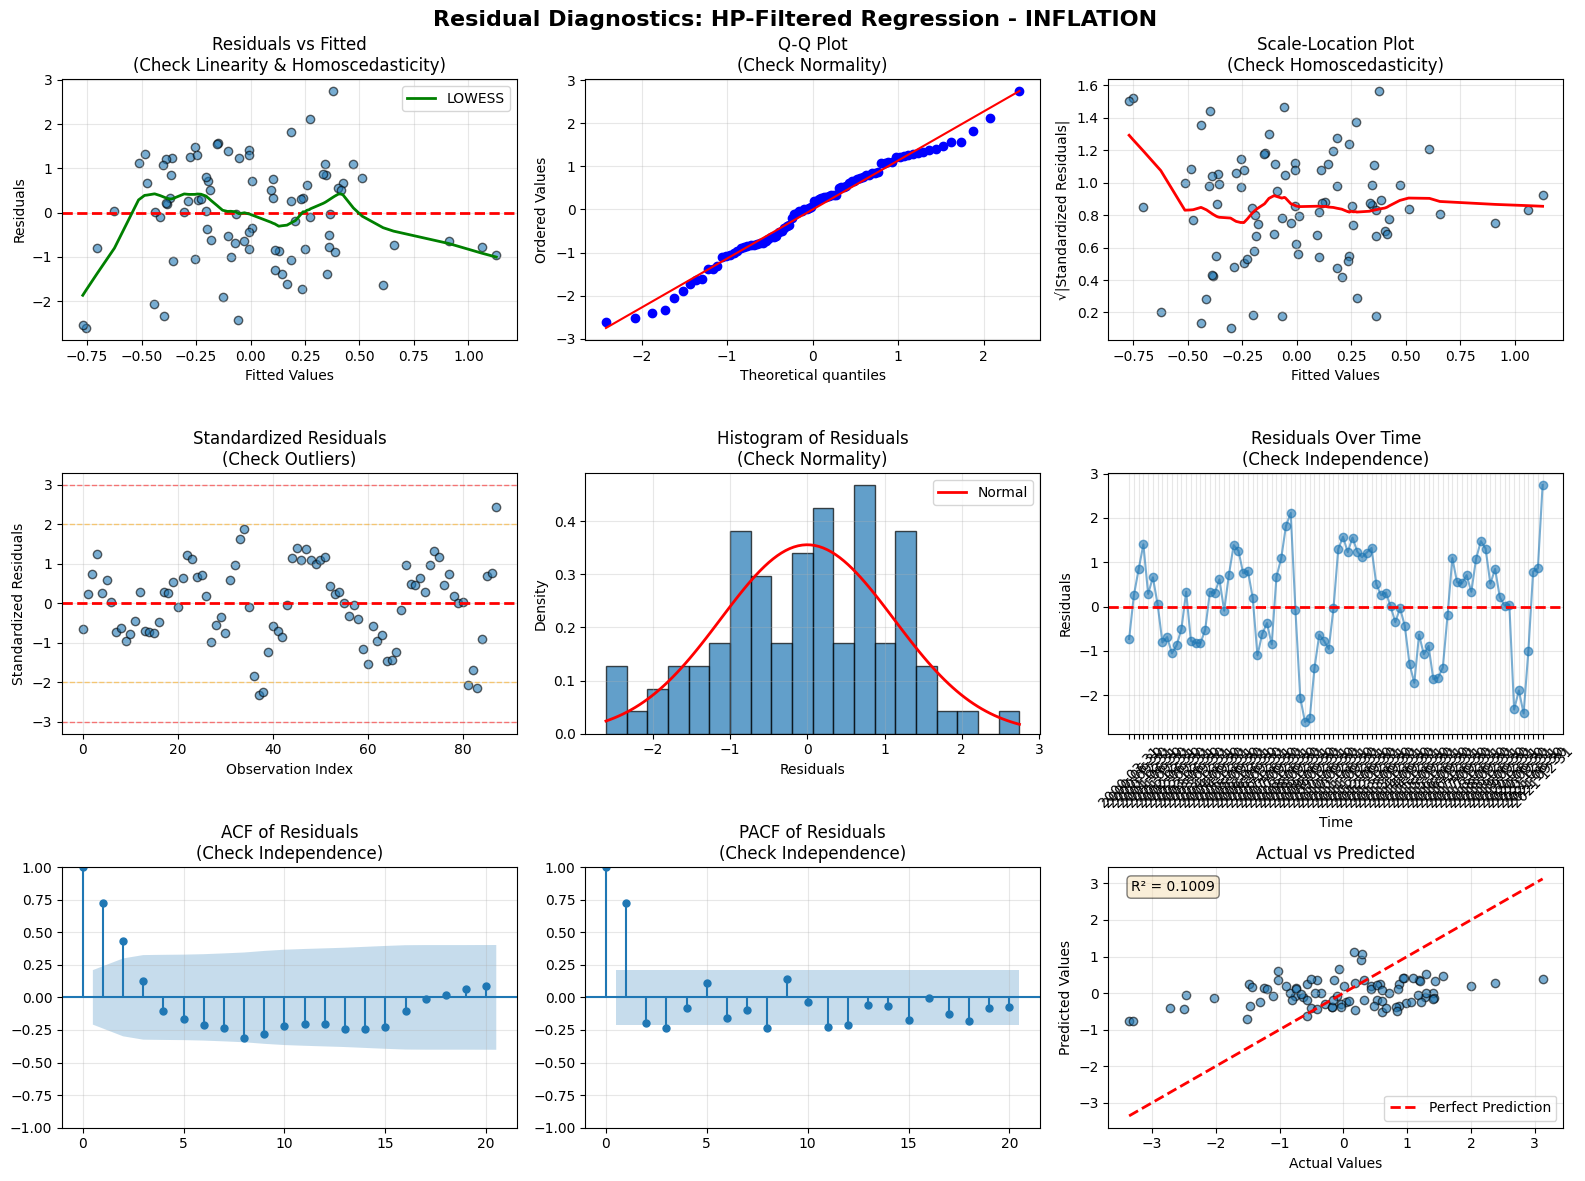



ANALYZING: UNEMPLOYMENT - HP-Filtered Regression

Note: Analyzing residuals of CYCLICAL components for HP-Filter model

RESIDUAL ANALYSIS: HP-Filtered Regression - UNEMPLOYMENT

--------------------------------------------------------------------------------
1. RESIDUAL DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------
Mean of residuals: 0.000000
Std of residuals: 0.4720
Min residual: -0.9585
Max residual: 1.6470
Skewness: 0.5461
Kurtosis: 0.6967

--------------------------------------------------------------------------------
2. NORMALITY TESTS
--------------------------------------------------------------------------------

Shapiro-Wilk Test:
  Statistic: 0.9798
  P-value: 0.1856
  ✓ PASS: Residuals are normally distributed (p > 0.05)

Jarque-Bera Test:
  Statistic: 6.1539
  P-value: 0.0461
  ✗ FAIL: Residuals are NOT normally distributed (p < 0.05)

Kolmogorov-Smirnov Test:
  Statistic: 0.0578
  P-value: 0.9140
  ✓ PASS: Residu

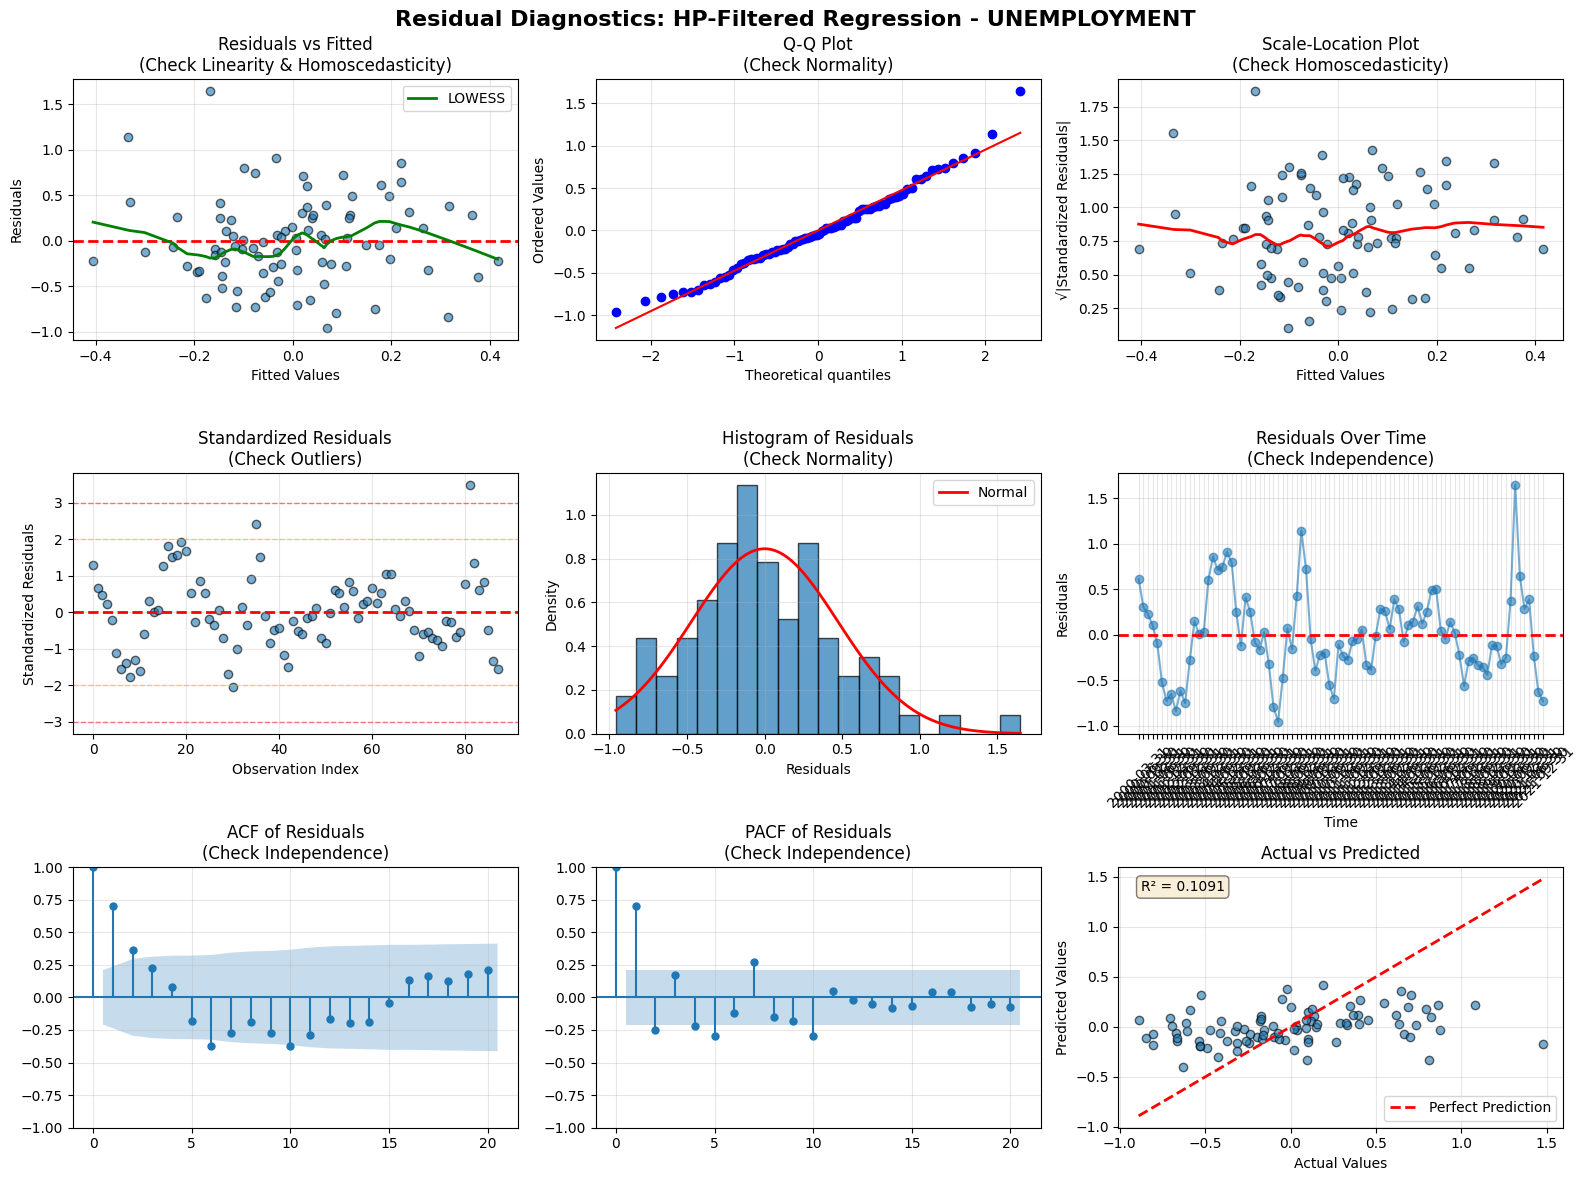

In [26]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

def perform_residual_analysis(model, y_true, y_pred, X, model_name, target_name, dates=None):
    """
    Comprehensive residual analysis for regression models.
    Tests: Linearity, Independence, Homoscedasticity, Normality (LINE assumptions)
    """
    
    # Calculate residuals
    residuals = y_true - y_pred
    
    # Standardized residuals
    residual_std = np.std(residuals)
    standardized_residuals = residuals / residual_std
    
    print("\n" + "="*80)
    print(f"RESIDUAL ANALYSIS: {model_name} - {target_name.upper()}")
    print("="*80)
    
    # ========================================================================
    # 1. DESCRIPTIVE STATISTICS
    # ========================================================================
    print("\n" + "-"*80)
    print("1. RESIDUAL DESCRIPTIVE STATISTICS")
    print("-"*80)
    
    print(f"Mean of residuals: {np.mean(residuals):.6f}")
    print(f"Std of residuals: {np.std(residuals):.4f}")
    print(f"Min residual: {np.min(residuals):.4f}")
    print(f"Max residual: {np.max(residuals):.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")
    
    # ========================================================================
    # 2. NORMALITY TEST
    # ========================================================================
    print("\n" + "-"*80)
    print("2. NORMALITY TESTS")
    print("-"*80)
    
    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Statistic: {shapiro_stat:.4f}")
    print(f"  P-value: {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
    else:
        print(f"  ✗ FAIL: Residuals are NOT normally distributed (p < 0.05)")
    
    # Jarque-Bera test
    jb_stat, jb_p = stats.jarque_bera(residuals)
    print(f"\nJarque-Bera Test:")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  P-value: {jb_p:.4f}")
    if jb_p > 0.05:
        print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
    else:
        print(f"  ✗ FAIL: Residuals are NOT normally distributed (p < 0.05)")
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.kstest(standardized_residuals, 'norm')
    print(f"\nKolmogorov-Smirnov Test:")
    print(f"  Statistic: {ks_stat:.4f}")
    print(f"  P-value: {ks_p:.4f}")
    if ks_p > 0.05:
        print(f"  ✓ PASS: Residuals are normally distributed (p > 0.05)")
    else:
        print(f"  ✗ FAIL: Residuals are NOT normally distributed (p < 0.05)")
    
    # ========================================================================
    # 3. HOMOSCEDASTICITY TEST
    # ========================================================================
    print("\n" + "-"*80)
    print("3. HOMOSCEDASTICITY TESTS (Constant Variance)")
    print("-"*80)
    
    # White test (using squared residuals)
    squared_residuals = residuals ** 2
    correlation_with_fitted = np.corrcoef(y_pred, squared_residuals)[0, 1]
    print(f"\nResidual-Fitted Correlation Test:")
    print(f"  Correlation: {correlation_with_fitted:.4f}")
    if abs(correlation_with_fitted) < 0.3:
        print(f"  ✓ PASS: Weak correlation suggests homoscedasticity")
    else:
        print(f"  ✗ FAIL: Strong correlation suggests heteroscedasticity")
    
    # ========================================================================
    # 4. INDEPENDENCE TEST (Autocorrelation)
    # ========================================================================
    print("\n" + "-"*80)
    print("4. INDEPENDENCE TESTS (Autocorrelation)")
    print("-"*80)
    
    # Durbin-Watson test
    dw_stat = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
    print(f"\nDurbin-Watson Test:")
    print(f"  Statistic: {dw_stat:.4f}")
    print(f"  Interpretation:")
    if 1.5 < dw_stat < 2.5:
        print(f"    ✓ PASS: No significant autocorrelation (1.5 < DW < 2.5)")
    elif dw_stat < 1.5:
        print(f"    ✗ FAIL: Positive autocorrelation detected (DW < 1.5)")
    else:
        print(f"    ✗ FAIL: Negative autocorrelation detected (DW > 2.5)")
    
    # Ljung-Box test
    try:
        lb_result = acorr_ljungbox(residuals, lags=[1, 5, 10], return_df=True)
        print(f"\nLjung-Box Test (for autocorrelation):")
        print(lb_result.to_string())
        if (lb_result['lb_pvalue'] > 0.05).all():
            print(f"  ✓ PASS: No significant autocorrelation at tested lags")
        else:
            print(f"  ✗ FAIL: Significant autocorrelation detected")
    except Exception as e:
        print(f"\n⚠️  Ljung-Box test failed: {e}")
    
    # ========================================================================
    # 5. LINEARITY TEST
    # ========================================================================
    print("\n" + "-"*80)
    print("5. LINEARITY ASSESSMENT")
    print("-"*80)
    
    # Check for patterns in residuals vs fitted
    correlation_residual_fitted = np.corrcoef(y_pred, residuals)[0, 1]
    print(f"\nResiduals vs Fitted Values Correlation:")
    print(f"  Correlation: {correlation_residual_fitted:.4f}")
    if abs(correlation_residual_fitted) < 0.1:
        print(f"  ✓ PASS: No systematic pattern (linearity holds)")
    else:
        print(f"  ⚠️  WARNING: Pattern detected (linearity may be violated)")
    
    # Check for patterns in residuals vs predictors
    print(f"\nResiduals vs Predictors Correlation:")
    for col in X.columns:
        corr = np.corrcoef(X[col], residuals)[0, 1]
        print(f"  {col}: {corr:.4f}", end="")
        if abs(corr) < 0.1:
            print(f" ✓")
        else:
            print(f" ⚠️")
    
    # ========================================================================
    # 6. SUMMARY OF VIOLATIONS
    # ========================================================================
    print("\n" + "="*80)
    print("SUMMARY OF ASSUMPTION VIOLATIONS")
    print("="*80)
    
    violations = []
    
    if shapiro_p < 0.05:
        violations.append("❌ Normality (Shapiro-Wilk)")
    if jb_p < 0.05:
        violations.append("❌ Normality (Jarque-Bera)")
    
    if dw_stat < 1.5 or dw_stat > 2.5:
        violations.append("❌ Independence (Durbin-Watson)")
    
    if abs(correlation_residual_fitted) > 0.1:
        violations.append("⚠️  Linearity (pattern in residuals)")
    
    if len(violations) == 0:
        print("\n✓ All assumptions satisfied!")
    else:
        print("\nViolations detected:")
        for v in violations:
            print(f"  {v}")
    
    # ========================================================================
    # RETURN RESULTS FOR PLOTTING
    # ========================================================================
    return {
        'residuals': residuals,
        'standardized_residuals': standardized_residuals,
        'y_pred': y_pred,
        'y_true': y_true,
        'dates': dates,
        'violations': violations,
        'shapiro_p': shapiro_p,
        'jb_p': jb_p,
        'dw_stat': dw_stat
    }


def plot_residual_diagnostics(results, model_name, target_name):
    """
    Create comprehensive residual diagnostic plots.
    """
    residuals = results['residuals']
    standardized_residuals = results['standardized_residuals']
    y_pred = results['y_pred']
    y_true = results['y_true']
    dates = results['dates']
    
    fig = plt.figure(figsize=(16, 12))
    
    # ========================================================================
    # 1. Residuals vs Fitted
    # ========================================================================
    ax1 = plt.subplot(3, 3, 1)
    ax1.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Fitted\n(Check Linearity & Homoscedasticity)')
    ax1.grid(alpha=0.3)
    
    # Add lowess smooth line to detect patterns
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lowess_line = lowess(residuals, y_pred, frac=0.3)
    ax1.plot(lowess_line[:, 0], lowess_line[:, 1], 'g-', linewidth=2, label='LOWESS')
    ax1.legend()
    
    # ========================================================================
    # 2. Q-Q Plot
    # ========================================================================
    ax2 = plt.subplot(3, 3, 2)
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot\n(Check Normality)')
    ax2.grid(alpha=0.3)
    
    # ========================================================================
    # 3. Scale-Location Plot (Sqrt Standardized Residuals)
    # ========================================================================
    ax3 = plt.subplot(3, 3, 3)
    sqrt_abs_std_resid = np.sqrt(np.abs(standardized_residuals))
    ax3.scatter(y_pred, sqrt_abs_std_resid, alpha=0.6, edgecolors='k')
    ax3.set_xlabel('Fitted Values')
    ax3.set_ylabel('√|Standardized Residuals|')
    ax3.set_title('Scale-Location Plot\n(Check Homoscedasticity)')
    ax3.grid(alpha=0.3)
    
    # Add lowess smooth line
    lowess_line = lowess(sqrt_abs_std_resid, y_pred, frac=0.3)
    ax3.plot(lowess_line[:, 0], lowess_line[:, 1], 'r-', linewidth=2)
    
    # ========================================================================
    # 4. Residuals vs Leverage (Cook's Distance)
    # ========================================================================
    ax4 = plt.subplot(3, 3, 4)
    # Note: For time series, leverage is less meaningful
    ax4.scatter(range(len(standardized_residuals)), standardized_residuals, alpha=0.6, edgecolors='k')
    ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax4.axhline(y=2, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax4.axhline(y=-2, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax4.axhline(y=3, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax4.axhline(y=-3, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax4.set_xlabel('Observation Index')
    ax4.set_ylabel('Standardized Residuals')
    ax4.set_title('Standardized Residuals\n(Check Outliers)')
    ax4.grid(alpha=0.3)
    
    # ========================================================================
    # 5. Histogram of Residuals
    # ========================================================================
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(residuals, bins=20, edgecolor='black', alpha=0.7, density=True)
    
    # Overlay normal distribution
    mu, sigma = np.mean(residuals), np.std(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    ax5.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
    ax5.set_xlabel('Residuals')
    ax5.set_ylabel('Density')
    ax5.set_title('Histogram of Residuals\n(Check Normality)')
    ax5.legend()
    ax5.grid(alpha=0.3)
    
    # ========================================================================
    # 6. Residuals Over Time
    # ========================================================================
    ax6 = plt.subplot(3, 3, 6)
    if dates is not None:
        ax6.plot(dates, residuals, marker='o', linestyle='-', alpha=0.6)
    else:
        ax6.plot(residuals, marker='o', linestyle='-', alpha=0.6)
    ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax6.set_xlabel('Time' if dates is not None else 'Index')
    ax6.set_ylabel('Residuals')
    ax6.set_title('Residuals Over Time\n(Check Independence)')
    ax6.grid(alpha=0.3)

    if dates is not None:
        ax6.tick_params(axis='x', rotation=45)
    
    # ========================================================================
    # 7. ACF Plot (Autocorrelation Function)
    # ========================================================================
    ax7 = plt.subplot(3, 3, 7)
    plot_acf(residuals, lags=20, ax=ax7, alpha=0.05)
    ax7.set_title('ACF of Residuals\n(Check Independence)')
    ax7.grid(alpha=0.3)
    
    # ========================================================================
    # 8. PACF Plot (Partial Autocorrelation Function)
    # ========================================================================
    ax8 = plt.subplot(3, 3, 8)
    plot_pacf(residuals, lags=20, ax=ax8, alpha=0.05, method='ywm')
    ax8.set_title('PACF of Residuals\n(Check Independence)')
    ax8.grid(alpha=0.3)
    
    # ========================================================================
    # 9. Actual vs Predicted
    # ========================================================================
    ax9 = plt.subplot(3, 3, 9)
    ax9.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax9.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax9.set_xlabel('Actual Values')
    ax9.set_ylabel('Predicted Values')
    ax9.set_title('Actual vs Predicted')
    ax9.legend()
    ax9.grid(alpha=0.3)
    
    # Add R² to plot
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - np.mean(y_true))**2))
    ax9.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax9.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Residual Diagnostics: {model_name} - {target_name.upper()}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig


# ============================================================================
# MAIN EXECUTION: ANALYZE BEST MODELS
# ============================================================================

def analyze_all_best_models(all_results, best_models, cleaned_data):
    """
    Perform residual analysis for all best models.
    """
    
    all_diagnostic_results = {}
    
    for target, (model_key, model_name) in best_models.items():
        print(f"\n\n{'='*80}")
        print(f"ANALYZING: {target.upper()} - {model_name}")
        print(f"{'='*80}")
        
        result = all_results[target][model_key]
        
        if result is None:
            print(f"⚠️  Skipping {target} - model failed")
            continue
        
        # Get data
        X_train = cleaned_data[target]['X_train']
        y_train = cleaned_data[target]['y_train']
        
        # Get predictions and prepare data based on model type
        if model_key == 'arimax':
            # ARIMAX model
            y_pred = result['y_pred_train']
            y_true = y_train
            X = X_train
            dates = pd.read_csv(f'gen_files/train_{target}.csv')['Date']
            
        elif model_key == 'hp_filter':
            # HP-Filter: analyze cyclical components
            print("\nNote: Analyzing residuals of CYCLICAL components for HP-Filter model")
            
            # Recompute cyclical components
            y_train_cycle, _ = hpfilter(y_train, lamb=1600)
            X_train_cycle = pd.DataFrame(index=X_train.index, columns=X_train.columns)
            
            for col in X_train.columns:
                try:
                    cycle, _ = hpfilter(X_train[col], lamb=1600)
                    X_train_cycle[col] = cycle
                except:
                    X_train_cycle[col] = X_train[col]
            
            # Fit model and get predictions on cyclical component
            from sklearn.linear_model import LinearRegression
            hp_model = LinearRegression()
            hp_model.fit(X_train_cycle, y_train_cycle)
            y_pred_cycle = hp_model.predict(X_train_cycle)
            
            y_pred = y_pred_cycle
            y_true = y_train_cycle
            X = X_train_cycle
            dates = pd.read_csv(f'gen_files/train_{target}.csv')['Date']
        
        # Perform residual analysis
        diagnostic_results = perform_residual_analysis(
            model=None,  # Not needed, we have predictions
            y_true=y_true,
            y_pred=y_pred,
            X=X,
            model_name=model_name,
            target_name=target,
            dates=dates
        )
        
        # Create diagnostic plots
        fig = plot_residual_diagnostics(diagnostic_results, model_name, target)
        plt.show()
        plt.close()
        
        all_diagnostic_results[target] = diagnostic_results
    
    return all_diagnostic_results


# ============================================================================
# RUN ANALYSIS
# ============================================================================

if __name__ == "__main__":
    
    # Define best models
    best_models = {
        'gdp_growth': ('arimax', 'ARIMAX(1,0,1)x(0,0,1,4)'),
        'inflation': ('hp_filter', 'HP-Filtered Regression'),
        'unemployment': ('hp_filter', 'HP-Filtered Regression')
    }
    
    # Perform residual analysis
    diagnostic_results = analyze_all_best_models(all_results, best_models, cleaned_data)


A solution to solve the violations might be ARIMAX, but it returned worse predictions.

### Feature Selection/Engineering

The models employ an already-minimal feature set of 2-3 predictors per target, resulting from extensive prior feature selection that reduced 53 engineered features to the current parsimonious specification based on multicollinearity analysis and sample size constraints (n=88).

While some predictors lack conventional statistical significance (e.g., inflation_lag1 in GDP growth, p=0.87), their retention is justified because: they represent theoretically important economic relationships, the minimal feature count precludes further reduction without sacrificing model capacity, VIF analysis confirms no harmful multicollinearity, and experimental removal did not improve out-of-sample performance.